In [1]:
import torch as tc
import numpy as np
from torch import nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

from tqdm import tqdm

from scipy.special import binom
from scipy.linalg import solve_continuous_lyapunov

from typing import Tuple

# Helpers

In [2]:
def eye(*args, **kwargs):
    return tc.from_numpy(np.eye(*args, **kwargs))

In [3]:
class MaternProcess():

    def __init__(self, p : int, magnitude : tc.Tensor, lengthscale : tc.Tensor):

        #sizes
        self.p = p #e.g., x, x', x'' has p=2
        
        #matern process constants
        self.magnitude = magnitude
        self.lengthscale = lengthscale
        self.nu = tc.tensor(1/2 + self.p)
        self.lamb = tc.sqrt(2 * self.nu) / self.lengthscale
        self.spectral_density = self.magnitude * 2 * tc.pi **(1/2) * tc.lgamma(self.nu + 1/2).exp() * (2 * self.nu)**(self.nu) / tc.lgamma(self.nu).exp() / (self.lengthscale ** (2 * self.nu))

        self.Ft = eye(p+1, k=1)
        self.Ft[-1, :] = tc.stack([- binom(p+1, i) * self.lamb**(p+1 - i) for i in range(p+1)])
        self.Lt = eye(1, p+1, k=p).T

        self.L_np = self.Lt.cpu().detach().numpy()
        self.F_np = self.Ft.cpu().detach().numpy()
        self.sol_lyapunov_np = solve_continuous_lyapunov(self.F_np, -self.L_np @ self.L_np.T)

        self.Sig0 = self.spectral_density * tc.tensor(self.sol_lyapunov_np) 

        return
    
    def forward(self, dt):
        A = tc.linalg.matrix_exp(dt * self.Ft)

        Sig = self.Sig0 - A @ self.Sig0 @ A.T

        return A, Sig

In [4]:
class Matern32Kernel:
    """
    Matern 3/2 Kernel class.
    Computes the Matern 3/2 kernel matrix given fixed lengthscale and magnitude.
    """
    def __init__(self, lengthscale: tc.Tensor, magnitude: tc.Tensor):
        """
        Args:
            lengthscale (torch.Tensor): Scalar tensor for the lengthscale parameter.
            magnitude (torch.Tensor): Scalar tensor for the magnitude (variance) parameter.
        """
        assert lengthscale.ndim == 0 and magnitude.ndim == 0, "lengthscale and magnitude must be scalars (0-d tensors)."
        assert lengthscale > 0, "lengthscale must be positive."
        assert magnitude > 0, "magnitude must be positive."

        self.lengthscale = lengthscale  # Fixed lengthscale tensor
        self.magnitude = magnitude      # Fixed magnitude tensor

    def forward(self, x1: tc.Tensor, x2: tc.Tensor):
        """
        Compute the Matern 3/2 kernel matrix.

        Args:
            x1 (torch.Tensor): Tensor of shape (n1, d), input points 1.
            x2 (torch.Tensor): Tensor of shape (n2, d), input points 2.

        Returns:
            torch.Tensor: Kernel matrix of shape (n1, n2).
        """
        # Normalize inputs using the lengthscale
        scaled_x1 = x1 / self.lengthscale
        scaled_x2 = x2 / self.lengthscale

        # Compute pairwise Euclidean distance
        distance = tc.cdist(scaled_x1, scaled_x2, p=2) + 1e-8  # Add epsilon for numerical stability

        # Compute Matern 3/2 kernel
        sqrt3_d = np.sqrt(3) * distance
        K = (1.0 + sqrt3_d) * tc.exp(-sqrt3_d)

        # Scale the kernel matrix with magnitude (variance)
        return self.magnitude * K

In [5]:
def IMQ_and_gradient(Y: tc.Tensor, m: tc.Tensor, beta: tc.Tensor, c: float, alpha : float = 1/2):
    assert Y.shape == m.shape, f"Y has shape {Y.shape} and m has shape {m.shape}. They must be of the same size."
    
    # Precompute shared intermediate terms
    diff = (Y - m) / c                      # Element-wise division
    diff_squared = diff.pow(2)              # Square of the difference
    one_plus_diff_squared = 1 + diff_squared  # (1 + ((Y - m) / c)^2)
    
    # Compute reciprocal square root for the IMQ term
    ralpha_term = one_plus_diff_squared.pow(-alpha)  # (1 + diff^2)^(-alpha)
    
    # IMQ term
    IMQ = beta * ralpha_term
    
    # Gradient-like term
    gradient_term = -beta * 2 * alpha * diff * (1/c) * one_plus_diff_squared.pow(-alpha -1) #-beta * alpha * (y-m) / c * (1/c) * (1 + (y-m)^2/c^2)^{-alpha - 1}
    
    
    return IMQ, gradient_term


In [6]:
from scipy.optimize import minimize
from numpy.linalg import cholesky, solve

def generate_A(d, r=1, base_strength=1.0, noise_level=0.1, seed=None):
    if seed is not None:
        np.random.seed(seed)
    # Shared signal: induces positive correlations
    shared_component = base_strength * np.ones((d, r))
    # Small random noise to avoid exact collinearity
    noise = noise_level * np.random.randn(d, r)
    A = shared_component + noise
    return A

def rbf_kernel(X1, X2, length_scale):
    X1 = np.ascontiguousarray(X1)
    X2 = np.ascontiguousarray(X2)
    
    dists = np.sum(X1**2, axis=1)[:, None] + \
            np.sum(X2**2, axis=1)[None, :] - 2 * X1 @ X2.T
    return np.exp(-0.5 * dists / length_scale**2)

class MOGPRegressor_NC:
    def __init__(self, mean=0.0, length_scale=1.0, noise=1e-2, A=None):
        self.D = A.shape[0]
        self.mean = mean
        self.length_scale = length_scale
        self.noise = noise
        self.A = A
        self.B = A @ A.T

    def fit(self, X_train, Y_train):
        self.X_train = X_train
        self.Y_train = Y_train
        self.N = len(X_train)

        # Flatten Y_train.T and mask out NaNs
        y_vec = Y_train.T.flatten()
        self.mask = ~np.isnan(y_vec)
        self.valid_idx = np.where(self.mask)[0]
        y_vec = y_vec[self.mask].reshape(-1, 1)
        
        self.y_vec = y_vec
        # Kernel matrix for all outputs
        full_K = np.kron(self.B, rbf_kernel(X_train, X_train, self.length_scale))
        noise_K = np.kron(self.noise * np.eye(self.D), np.eye(self.N))
        K = full_K + noise_K + 1e-6 * np.eye(self.D * self.N)

        # Subset kernel matrix and solve only for valid indices
        self.K_noise = K[np.ix_(self.mask, self.mask)]
        y_centered = self.y_vec - self.mean

        self.L = cholesky(self.K_noise)
        self.alpha = solve(self.L.T, solve(self.L, y_centered))


    def predict(self, X_test):
        N_test = len(X_test)
        K_s = np.kron(self.B, rbf_kernel(self.X_train, X_test, self.length_scale))
        K_s = K_s[self.valid_idx, :]  # Subset only rows corresponding to observed outputs

        K_ss = np.kron(self.B, rbf_kernel(X_test, X_test, self.length_scale)) + \
               1e-6 * np.eye(N_test * self.D)

        mu = K_s.T @ self.alpha + self.mean
        v = solve(self.L, K_s)
        cov = K_ss - v.T @ v
        var = np.maximum(0, np.diag(cov))  # Avoid small negative variances due to numerical errors

        mu = mu.reshape(self.D, -1).T
        var = var.reshape(self.D, -1).T

        return mu, var

    def log_marginal_likelihood(self, theta=None):
        if theta is not None:
            length_scale = np.exp(theta)[0]
            noise = np.exp(theta)[1]
            A = theta[2:].reshape(self.D, -1)
            B = A @ A.T
            full_K = np.kron(B, rbf_kernel(self.X_train, self.X_train, length_scale))
            noise_K = np.kron(noise * np.eye(self.D), np.eye(self.N))
            K = full_K + noise_K + 1e-6 * np.eye(self.D * self.N)
        else:
            K = self.K_noise
        K = K[np.ix_(self.valid_idx, self.valid_idx)]
        y_centered = self.y_vec - self.mean

        try:
            L = cholesky(K)
        except np.linalg.LinAlgError:
            return 1e6

        alpha = solve(L.T, solve(L, y_centered))
        log_det = 2 * np.sum(np.log(np.diag(L)))
        result = -0.5 * y_centered.T @ alpha - 0.5 * log_det - 0.5 * len(y_centered) * np.log(2 * np.pi)
        return result.item()

    def optimize_hyperparameters(self, print_opt_param = False, print_iter_param=False):
        def objective(theta):
            val = -self.log_marginal_likelihood(theta)
            if print_iter_param:
                print(-val)
            return val

        initial_theta = np.concatenate((
            np.log([self.length_scale, self.noise]),
            self.A.reshape(-1)
        ))

        # bounds = [
        #     (np.log(1e-2), np.log(1e2)),     # length_scale
        #     (np.log(1e-5), np.log(1.0)),     # noise
        # ] + [(np.log(1e-1), np.log(5))] * len(self.a)

        res = minimize(objective, initial_theta, method='L-BFGS-B')

        self.length_scale = np.exp(res.x[0])
        self.noise = np.exp(res.x[1])
        self.A = res.x[2:].reshape(self.D,-1)
        self.B = self.A @ self.A.T

        if print_opt_param:
            print(f"Optimized length_scale: {self.length_scale:.4f}, noise: {self.noise:.6f}")
            print(f"Optimized A: {self.A}")
            print(f"Optimized B: \n{self.B}")

        self.fit(self.X_train, self.Y_train)

    def loo_cv(self, length_scale, noise, A):
        B = A @ A.T
        loo_K = np.kron(B, rbf_kernel(self.X_train, self.X_train, length_scale))
        loo_K_noise = loo_K + noise * np.eye(self.D * self.N) + 1e-6 * np.eye(self.D * self.N)
        loo_K_noise_inv = np.linalg.inv(loo_K_noise[np.ix_(self.mask, self.mask)])
        loo_K_noise_inv_diag = np.diag(loo_K_noise_inv).reshape(-1,1)

        # Compute LOO predictions
        loo_mean = self.y_vec - loo_K_noise_inv @ self.y_vec / loo_K_noise_inv_diag
        loo_var = 1 / loo_K_noise_inv_diag

        # print('loo_var', loo_var.shape)
        # print('loo_mean', loo_mean.shape)
        # print('self.y_train', self.y_train.shape)

        predictive_log_prob = -0.5 * np.log(loo_var) - 0.5 * (loo_mean - self.y_vec)**2/loo_var - 0.5 * np.log(np.pi * 2)

        return np.sum(predictive_log_prob)

In [7]:
def extract_and_remove_dth(matrix, d):
    row_without_diag = tc.cat((matrix[d, :d], matrix[d, d+1:]))
    diag_elem = matrix[d, d]
    reduced_matrix = tc.cat((matrix[:d], matrix[d+1:]), dim=0)
    reduced_matrix = tc.cat((reduced_matrix[:, :d], reduced_matrix[:, d+1:]), dim=1)
    return row_without_diag, diag_elem, reduced_matrix

def cross_channel_predictive(Y_train, mean, B, noise):
    N, D = Y_train.shape[:2]
    device = Y_train.device  # Ensure operations remain on the same device
    noise_matrix = noise * tc.eye(D, device=device)

    B_noise = B + noise_matrix
    predictive_means = tc.zeros_like(Y_train)
    predictive_variances = tc.zeros_like(Y_train)

    for i in range(N):
        row = Y_train[i, :]
        for d in range(D):
            obs_other = tc.cat((row[:d], row[d+1:]))
            B_d_other, B_dd, B_other_other = extract_and_remove_dth(B_noise, d)

            B_d_other_masked = B_d_other
            B_other_other_masked = B_other_other + 1e-3 * tc.eye(len(B_other_other), device=device)
            obs_other_masked = obs_other

            inv_B = tc.linalg.inv(B_other_other_masked)
            residual = (obs_other_masked - mean)#.unsqueeze(1)
            B_d_other_masked = B_d_other_masked.unsqueeze(0)

            # print((obs_other_masked - mean).shape)
            conditional_mean = mean + (B_d_other_masked @ inv_B @ residual).squeeze()
            conditional_variance = B_dd - (B_d_other_masked @ inv_B @ B_d_other_masked.T).squeeze()

            predictive_means[i, d] = conditional_mean
            predictive_variances[i, d] = conditional_variance

    return predictive_means, predictive_variances

In [8]:
def plot_spatio_temporal(idx, grid, ts, pred, Ys, Ys_no_outliers, outliers_loc, true_Ys, n_lon, n_lat):

    x,y = grid[:, 0], grid[:, 1]
    X = x.reshape(n_lon, n_lat)
    Y = y.reshape(n_lon, n_lat)
    
    pred = pred[idx].reshape(n_lon, n_lat)
    Ys = Ys[idx].reshape(n_lon, n_lat)
    Ys_no_outliers = Ys_no_outliers[idx].reshape(n_lon, n_lat)
    true_Ys = true_Ys[idx].reshape(n_lon, n_lat)


    fig, axs = plt.subplots(1, 3, figsize=(12,3))
    kwargs = {"levels" : 10, "cmap": "YlGnBu"}

    outliers_loc_t = outliers_loc[np.where(np.isclose(outliers_loc[:, 0], ts[idx]))]

    axs[0].contourf(X, Y, pred, **kwargs)
    axs[1].contourf(X, Y, Ys_no_outliers, **kwargs)
    axs[1].scatter(outliers_loc_t[:, 1], outliers_loc_t[:, 2], marker='.', s=30., color='red')
    axs[2].contourf(X, Y, true_Ys, **kwargs)
    
    axs[0].set_title("Prediction")
    axs[1].set_title("Data")
    axs[2].set_title("True Latent Function")

    print("Mean Absolute Difference (Data - No Outliers) : ", np.abs(Ys_no_outliers - true_Ys).sum().item())
    print("Mean Absolute Difference (Prediction) : ", np.abs(pred - true_Ys).sum().item())

    return

# Sparse

In [ ]:
class SparseSpatioTemporalRCGP(nn.Module):
    """
    Spatio-Temporal Robust and Conjugate Gaussian Process.
    """
    def __init__(self, 
                 ts : tc.Tensor,
                 grid : tc.Tensor,
                 Ys : tc.Tensor,
                 sparse_pts : int,
                 p : int = 1,
                 raw_var_y_init : float = 1.0,
                 raw_temporal_lengthscale_init : float = 1.0,
                 raw_temporal_magnitude_init : float = 1.0,
                 raw_spatial_lengthscale_init : float = 1.0,
                 raw_spatial_magnitude_init : float = 1.0,
                 IMQ_exponent : float = 1/2,
                 ):
        """
        Initialization phase prior to hyperparameter optimization or inference/prediction. 

        Args:
            ts (tc.Tensor): time vector of size (n_t, 1). Must not contain nulls, inf, and must be strictly increasing.
            grid (tc.Tensor): Grid at which data is located, of size (n_r, d-1). Fixed across time. Must not contain nulls, inf.
            Ys (tc.Tensor): Data, of size (n_t, n_r, 1). If at a time step, there are any nulls, data will not be used for prediction.
            p (int, optional): Number of temporal derivatives modelled (>0). Greater p means more smoothness. Defaults to 1.
        """
        super().__init__()
        
        #Initial checks
        (self.n_r, self._n_t, self.d) = self.initialize(p=p, ts=ts, grid=grid, Ys=Ys)
        
        self.grid = grid.to(tc.float32)
        self._ts = ts.to(tc.float32) #original ts (without padding)
        self._Ys = Ys.to(tc.float32) #original Ys (without padding)

        #Padding filtering time array and data array
        (self.n_t, self.Ys, self.ts) = self.padding(ts=self._ts, Ys=self._Ys)

        self.__prior_mean_funcs = ["constant", "local_constant", "m_pred", "spatial"]

        self.__fixed_params = {"p" : p, #temporal Matern kernel (nu_{temporal} = p + 1/2)
                               "robust" : False, #Not automatically robust!
                               "prior_mean" : "constant",
                               "beta" : None, #If None, will be sqrt(var_y / 2)
                               "is_beta_fixed" : False,
                               "c" : 1., #If None and is_c_fixed=True, will be c_factor * sqrt(var_y). 
                               "c_factor" : 1.,
                               "is_c_fixed": True, #When false, c is adaptive and = 2 * predicted std
                               }

        self._raw_var_y = nn.Parameter(tc.tensor(raw_var_y_init, dtype=tc.float32))
        self._raw_temporal_lengthscale = nn.Parameter(tc.tensor(raw_temporal_lengthscale_init, dtype=tc.float32))
        self._raw_temporal_magnitude = nn.Parameter(tc.tensor(raw_temporal_magnitude_init, dtype=tc.float32))
        self._raw_spatial_lengthscale = nn.Parameter(tc.tensor(raw_spatial_lengthscale_init, dtype=tc.float32))
        self._raw_spatial_magnitude = nn.Parameter(tc.tensor(raw_spatial_magnitude_init, dtype=tc.float32))

        assert isinstance(sparse_pts, int) and sparse_pts > 0, "Number of sparse points must be an integer greater than 0."
        self.__n_u = sparse_pts #number of sparse points

        self.sparse_grid = nn.Parameter(tc.nn.init.uniform_(tc.empty(size=(self.__n_u, self.d - 1), dtype=tc.float32)))

        self.IMQ_exponent = float(IMQ_exponent)
        
        self.Id_z = eye(self.n_r).to(tc.float32)
        self.Id_sparse = eye(self.__n_u).to(tc.float32)

        self.H0 = eye(1, (1+self.__fixed_params["p"]), k=0).to(tc.float32) #measurement matrix -> temporal only case
        self.H = tc.kron(self.Id_sparse, self.H0).to(tc.float32) #measurement matrix 

        self.latent_size = self.__n_u * (p + 1)

        self.K_w = None #For prior mean
        self._K_w_lengthscale = 4.

        return
    

    @property
    def fixed_params(self):
        return self.__fixed_params

    @property
    def var_y(self):
        return F.softplus(self._raw_var_y)
    
    @var_y.setter
    def var_y(self, value):
        """
        Setter for the variance in y.
        """
        if value <= 0:
            raise ValueError("Parameter must be positive.")
        # Reverse transform: raw_parameter = log(exp(value) - 1)
        self._raw_var_y.data = tc.log(tc.exp(tc.tensor(value, dtype=tc.float32)) - 1)

    @property
    def beta(self):
        if self.__fixed_params["is_beta_fixed"]:

            if isinstance(self.__fixed_params["beta"], (float, int)):
                return tc.tensor(self.__fixed_params["beta"], dtype=tc.float32)
            
            elif isinstance(self.__fixed_params["beta"], tc.Tensor):
                return self.__fixed_params["beta"]
            else:
                raise ValueError(f"{self.__fixed_params["beta"]} is an invalid data type for beta.")
        else:
            return tc.sqrt(self.var_y / 2)#.clone().detach()
    
    @beta.setter
    def beta(self, value : float):
        if isinstance(value, tc.Tensor):
            self.__fixed_params["beta"] = value

        elif isinstance(value, (float, int)):
            self.__fixed_params["beta"] = tc.tensor(value, dtype=tc.float32)

        elif value is None: #If we set beta = None, we want to revert back to adaptive beta. 
            self.__fixed_params["beta"] = None
            self.__fixed_params["is_beta_fixed"] = False
            return
        else:
            raise ValueError(f"{value} is not a valid value for parameter beta.")
        
        self.__fixed_params["is_beta_fixed"] = True
        return
    
    @property
    def c(self):
        if isinstance(self.__fixed_params["c"], (float, int)):
            return tc.tensor(self.__fixed_params["c"], dtype=tc.float32)
        
        elif isinstance(self.__fixed_params["c"], tc.Tensor):
            return self.__fixed_params["c"]
        else:
            return self.__fixed_params["c_factor"] * tc.sqrt(self.var_y)#.clone().detach()
    
    @c.setter
    def c(self, value : float):
        if isinstance(value, tc.Tensor):
            self.__fixed_params["c"] = value
            
        elif isinstance(value, (float, int)):
            self.__fixed_params["c"] = tc.tensor(value, dtype=tc.float32)

        elif value is None:
            self.__fixed_params["c"] = None

        else:
            raise ValueError(f"{value} is not a valid value for parameter c.")
        
        self.__fixed_params["is_c_fixed"] = True
        return
    
    def adaptive_c(self):
        self.__fixed_params["is_c_fixed"] = False
        return

    @property
    def temporal_lengthscale(self):
        return F.softplus(self._raw_temporal_lengthscale)
    
    @temporal_lengthscale.setter
    def temporal_lengthscale(self, value):
        """
        Setter for the temporal lengthscale.
        """
        if value <= 0:
            raise ValueError("Temporal lengthscale must be positive.")
        # Reverse transform: raw_parameter = log(exp(value) - 1)
        if isinstance(value, tc.Tensor):
            self._raw_temporal_lengthscale.data = tc.log(tc.exp(value) - 1)
        else:
            self._raw_temporal_lengthscale.data = tc.log(tc.exp(tc.tensor(value, dtype=tc.float32)) - 1)

    @property
    def temporal_magnitude(self):
        return F.softplus(self._raw_temporal_magnitude)
    
    @temporal_magnitude.setter
    def temporal_magnitude(self, value):
        """
        Setter for the temporal magnitude.
        """
        if value <= 0:
            raise ValueError("Temporal magnitude must be positive.")
        # Reverse transform: raw_parameter = log(exp(value) - 1)
        if isinstance(value, tc.Tensor):
            self._raw_temporal_magnitude.data = tc.log(tc.exp(value) - 1)
        else:
            self._raw_temporal_magnitude.data = tc.log(tc.exp(tc.tensor(value, dtype=tc.float32)) - 1)

    @property
    def spatial_lengthscale(self):
        return F.softplus(self._raw_spatial_lengthscale)
    
    @spatial_lengthscale.setter
    def spatial_lengthscale(self, value):
        """
        Setter for the spatial lengthscale.
        """
        if value <= 0:
            raise ValueError("Spatial lengthscale must be positive.")
        # Reverse transform: raw_parameter = log(exp(value) - 1)
        if isinstance(value, tc.Tensor):
            self._raw_spatial_lengthscale.data = tc.log(tc.exp(value) - 1)
        else:
            self._raw_spatial_lengthscale.data = tc.log(tc.exp(tc.tensor(value, dtype=tc.float32)) - 1)

    @property
    def spatial_magnitude(self):
        return F.softplus(self._raw_spatial_magnitude)
    
    @spatial_magnitude.setter
    def spatial_magnitude(self, value):
        """
        Setter for the spatial magnitude.
        """
        if value <= 0:
            raise ValueError("Spatial magnitude must be positive.")
        # Reverse transform: raw_parameter = log(exp(value) - 1)
        if isinstance(value, tc.Tensor):
            self._raw_spatial_magnitude.data = tc.log(tc.exp(value) - 1)
        else:
            self._raw_spatial_magnitude.data = tc.log(tc.exp(tc.tensor(value, dtype=tc.float32)) - 1)

    
    def initialize(self, p, ts, grid, Ys) -> Tuple[int, int, int]:

        #checks on p
        assert type(p) == int and p > 0, "p must be an integer greater than 0."

        #checks on ts
        assert ts.ndim == 2 and ts.shape[1] == 1, "ts must be two-dimensional, with n_t rows and one column."
        if tc.isnan(ts).any(): raise ValueError("time values contain NaN values.")
        if tc.isinf(ts).any(): raise ValueError("time values contain Inf values.")
        if not tc.all(ts[1:] - ts[:-1] > 0): ValueError("time values are not strictly increasing.")

        #checks on grid
        assert grid.ndim == 2, "grid must be two-dimensional, with n_r rows and d columns."
        if tc.isnan(grid).any(): raise ValueError("grid contains NaN values.")
        if tc.isinf(grid).any(): raise ValueError("grid contains Inf values.")

        #checks on Ys
        assert Ys.ndim == 3 and Ys.shape==(len(ts), len(grid), 1), "Ys must be of shape (n_t, n_r, 1), where n_t is the number of time steps, n_r the size of the grid. Also possible that grid has the wrong number of rows."
        if tc.isinf(Ys).any(): raise ValueError("Ys contains Inf values.")

        n_r = grid.shape[0]
        n_t = ts.shape[0]
        d = grid.shape[1] + 1 #number of spatial and temporal dimensions (hence the +1 for temporal)

        return n_r, n_t, d
 

    def padding(self, ts : tc.Tensor, Ys : tc.Tensor):

        t0 = (ts[0] - (ts[1] - ts[0])).unsqueeze(0)
        tf = (ts[-1] + (ts[-1] - ts[-2])).unsqueeze(0)

        ts_filtering = tc.concatenate([t0, ts, tf])
        n_t_filtering = ts_filtering.shape[0]

        nan_row = tc.full((1, self.n_r, 1), float('nan'))

        Ys_filtering = tc.cat([nan_row, Ys, nan_row], dim=0)

        return n_t_filtering, Ys_filtering.to(tc.float32), ts_filtering.to(tc.float32)
    

    def v(self, Y : tc.Tensor, weights : tc.Tensor, partial_weights : tc.Tensor):

        if not self.__fixed_params["robust"]:
            R_inv = self.R_inv(Y=Y, weights=weights, partial_weights=partial_weights)[0]
            return R_inv @ Y
        else:
            return (2/self.var_y**2) * (weights**2 * Y - 2 * self.var_y * weights * partial_weights)


    def R_inv(self, Y : tc.Tensor, weights : tc.Tensor, partial_weights : tc.Tensor):
        #Return R_inv, R
        if not self.__fixed_params["robust"]:
            return 1/self.var_y * tc.eye(self.Ys.shape[1]), self.var_y * tc.eye(self.Ys.shape[1])
        else:
            #return self.var_y**2 / 2 * tc.diag(weights.squeeze(dim=-1)**(-2))
            return (2/self.var_y**2) * tc.diag(weights.flatten()**2), (self.var_y**2 / 2) * tc.diag(weights.flatten()**(-2))


    def get_matrices(self, dt : float, temporal_kernel : MaternProcess, spatial_kernel : Matern32Kernel):
        
        At, Sigt = temporal_kernel.forward(dt)

        K_uu = spatial_kernel.forward(self.sparse_grid, self.sparse_grid)
        K_zu = spatial_kernel.forward(self.grid, self.sparse_grid)
        K_zz = spatial_kernel.forward(self.grid, self.grid)

    
        A = tc.kron(self.Id_sparse, At) 
        Sig = tc.kron(K_uu, Sigt)

        return A.to(tc.float32), Sig.to(tc.float32), (K_uu, K_zu, K_zz)
    

    def activate_robustness(self, func : str):
        if func in self.__prior_mean_funcs:
            self.__fixed_params["prior_mean"] = func
            self.__fixed_params["robust"] = True
        else:
            raise ValueError(f"{func} is not in {self.__prior_mean_funcs}.")

        return
    

    def deactivate_robustness(self):
        self.__fixed_params["robust"] = False
        return
    

    def set_prior_mean(self, func : str):
        self.__fixed_params["prior_mean"] = func


    def compute_K_w(self):
        k = Matern32Kernel(lengthscale=tc.tensor(self._K_w_lengthscale), magnitude=tc.tensor(1.))

        final_arr = tc.empty((self.n_r, self.n_r))

        for i in range(self.n_r):
            final_arr[i, :] = k.forward(self.grid[[i]], self.grid)
            final_arr[i, :] = final_arr[i, :] / final_arr[i, :].sum() #Normalizing, since these are weights

        return final_arr


    def prior_mean(self, Y : tc.Tensor, m_prior : tc.Tensor):

        if self.__fixed_params["prior_mean"] == 'constant':
            mean = self.Ys.nanmean() * tc.ones_like(Y) #nan mean because we might encounter NaNs in the data (we actually buffer with NaNs)
            return mean
        
        if self.__fixed_params["prior_mean"] == 'local_constant':
            return self.K_w @ Y
        
        elif self.__fixed_params["prior_mean"] == 'm_pred':
            return m_prior

        elif self.__fixed_params["prior_mean"] == "spatial":
            return self.K_w @ m_prior
        
        else:
            return m_prior
        

    def compute_weights(self, Y : tc.Tensor, m_prior : tc.Tensor, P_prior : tc.Tensor):

        if not self.__fixed_params["robust"]:
            return tc.sqrt(self.var_y / 2).clone().detach() * tc.ones_like(Y), tc.zeros_like(Y)
        else:
            m = self.prior_mean(Y=Y, m_prior=m_prior)

            if self.__fixed_params["is_c_fixed"]:
                c = self.c
            else:
                with tc.no_grad():
                    #c = 1.
                    c = tc.sqrt(tc.diagonal(P_prior) + self.var_y - self.var_y * tc.diagonal(P_prior))#.clone().detach() 
                    c = c.reshape(-1, 1)

            weights, partial_y_weights = IMQ_and_gradient(Y=Y, m=m, beta=self.beta, c=c, alpha=self.IMQ_exponent)

            return weights, partial_y_weights
    

    def predict_step(self, A : tc.Tensor, Sig : tc.Tensor, m : tc.Tensor, P : tc.Tensor):
        m_pred = A @ m  # Predict state
        P_pred = A @ P @ A.T + Sig  # Predict covariance
        return m_pred.to(tc.float32), P_pred.to(tc.float32)
    
    
    def update_step(self, m_pred : tc.Tensor, P_pred : tc.Tensor, Y : tc.Tensor, spatial_kernel_matrices : Tuple[tc.Tensor, tc.Tensor, tc.Tensor]):

        u_hat = self.H @ m_pred #Prediction of sparse mean
        H_P_pred = self.H @ P_pred #Partial prediction of sparse covariance

        K_uu, K_zu, K_zz = spatial_kernel_matrices

        K_uu_inv = tc.linalg.inv(K_uu)

        f_hat = K_zu @ K_uu_inv @ u_hat
        P_hat = K_zu @ K_uu_inv @ self.H @ P_pred @ self.H.T @ K_uu_inv @ K_zu.T + self.temporal_magnitude * (K_zz - K_zu @ K_uu_inv @ K_zu.T)


        weights, partial_weights = self.compute_weights(Y=Y, m_prior=f_hat, P_prior=P_hat) #Weights Computation
        R_inv_k, R_k = self.R_inv(Y=Y, weights=weights, partial_weights=partial_weights)


        S_k = R_k + P_hat  
        
        K_k = tc.linalg.solve(S_k.T, K_zu @ K_uu_inv @ self.H @ P_pred).T

        
        # Innovation term 
        v_k = self.v(Y=Y, weights=weights, partial_weights=partial_weights)  
        innovation = R_k @ v_k - f_hat 
        
        # Updated mean
        m_updated = m_pred + K_k @ innovation  
        
        # Updated covariance
        P_updated = P_pred - (K_k @ S_k @ K_k.T) 

        return m_updated, P_updated, weights


    
    def filtsmooth(self, temporal_kernel : MaternProcess, spatial_kernel : Matern32Kernel, m0 : tc.Tensor, P0 : tc.Tensor, smoothing : bool):

        #Where we store the state, covariance estimates m_{k|k}, P_{k|k}
        ms = tc.empty(size=(self.n_t, self.latent_size, 1), dtype=tc.float32) #n_t time steps where n_t is len(ts) + 2 (padded). latent size depends on number of spatial dimensions and temporal derivatives
        Ps = tc.empty(size=(self.n_t, self.latent_size, self.latent_size), dtype=tc.float32) #same here. 
        
        #Container for the weights. Choosing lists because might have to autodiff through weights and inplace assignment is no good for autodiff.
        W0 = tc.zeros(size=(self.n_r, 1))
        Ws = [W0]

        #Where we store the one-step predictions/predictives  p(z_k | y_{1:k-1})
        m_preds, P_preds = [m0], [P0]

        #Initialize the 0th step. No data observed on 0th step. We always do look-ahead predict and update (i.e. from k, predict k+1 and update with data at k+1)
        m, P = m0, P0 #m, P are the "running" state and covariance matrix. They get overwritten. 

        dt = (self.ts[1] - self.ts[0]).item()
        A, Sig, spatial_kernel_matrices = self.get_matrices(dt=dt, temporal_kernel=temporal_kernel, spatial_kernel=spatial_kernel) #Get the transition matrix and the noise matrix

        ms[0], Ps[0] = m0.clone().detach(), P0.clone().detach()

        #Filtering
        for k in range(self.n_t - 1):

            #--------------------Predict Step------------------------
            m_pred, P_pred = self.predict_step(A=A, Sig=Sig, m=m, P=P) #Get state,covariance estimate of z_k for y_{k+1}
            
            m_preds.append(m_pred)
            P_preds.append(P_pred)

            #---------------------Update Step------------------------
            if tc.isnan(self.Ys[k+1]).any(): #If data is incomplete we don't perform update step. 
                m = m_pred
                P = P_pred

                Ws.append(W0.clone().detach()) #Weights are zero because we don't want to include in calculation a value of 0.
                ms[k+1] = m_pred.clone().detach() #We store the predictive mean m_{k+1|k} as the mean estimate m_{k+1|k+1}
                Ps[k+1] = P_pred.clone().detach() #We store the predictive step cov P_{k+1|k} as the cov estimate P_{k+1|k+1}

            else: #Update with data at k+1 when there is no missing data
                m_updated, P_updated, weights = self.update_step(m_pred=m_pred, P_pred=P_pred, Y=self.Ys[k+1], spatial_kernel_matrices=spatial_kernel_matrices)

                m = m_updated
                P = P_updated

                ms[k+1] = m_updated.clone().detach()
                Ps[k+1] = P_updated.clone().detach()
                Ws.append(weights.clone().detach()) 


        #Stacking
        Ws = tc.stack(Ws) 
        m_preds = tc.stack(m_preds)
        P_preds = tc.stack(P_preds)

        if smoothing:
            #RTS Smoothing
            for k in range(self.n_t - 2, -1, -1):  
                #C = Ps[k] @ A.T @ tc.linalg.inv(P_preds[k+1].clone().detach())
                C = tc.linalg.solve(P_preds[k+1].clone().detach().T, A @ Ps[k].T).T

                ms[k] = ms[k] + C @ (ms[k+1] - m_preds[k+1].clone().detach())
                Ps[k] = Ps[k] + C @ (Ps[k+1] - P_preds[k+1].clone().detach()) @ C.T
                
        return ms, Ps, m_preds, P_preds, Ws
    

    def forward(self, smoothing=True):
        
        #Instantiate the temporal kernel
        temporal_kernel = MaternProcess(p=self.__fixed_params["p"],
                                        lengthscale=self.temporal_lengthscale,
                                        magnitude=self.temporal_magnitude,
                                        )


        spatial_kernel = Matern32Kernel(lengthscale=self.spatial_lengthscale,
                                       magnitude=self.spatial_magnitude,
                                       )
            
        self.K_w = self.compute_K_w()

            #Initialize m0 as zeros, since the first step is always a "calibration step" and no data is observed at 0 (because of padding).
            #P0 is the kronecker between spatial kernel and temporal covariance at time 0 (\Sigma_\infty)
            
        m0=tc.zeros(size=(self.latent_size, 1), dtype=tc.float32)

        P0=tc.kron(spatial_kernel.forward(self.sparse_grid, self.sparse_grid), temporal_kernel.Sig0).to(tc.float32)


        ms, Ps, m_preds, P_preds, Ws = self.filtsmooth(m0=m0, P0=P0, spatial_kernel=spatial_kernel, temporal_kernel=temporal_kernel, smoothing=smoothing)

        _, _, (K_uu, K_zu, K_zz) = self.get_matrices(dt=0, temporal_kernel=temporal_kernel, spatial_kernel=spatial_kernel)

        K_uu_inv = tc.linalg.inv(K_uu)

        preds_filt = (K_zu @ K_uu_inv @ self.H @ m_preds)[1:-1]  
        covs_filt = (K_zu @ K_uu_inv @ self.H @ P_preds @ self.H.T @ K_uu_inv @ K_zu.T + self.temporal_magnitude * (K_zz - K_zu @ K_uu_inv @ K_zu.T))[1:-1]

        preds_smooth = (K_zu @ K_uu_inv @ self.H @ ms)[1:-1].squeeze(-1)
        covs_smooth = (K_zu @ K_uu_inv @ self.H @ Ps @ self.H.T @ K_uu_inv @ K_zu.T + self.temporal_magnitude * (K_zz - K_zu @ K_uu_inv @ K_zu.T))[1:-1]

        stds_smooth = tc.sqrt(tc.diagonal(covs_smooth, dim1=1, dim2=2)).squeeze()

        R = self.var_y * tc.eye(self.n_r)
        Ws_norm = Ws[1:-1] / Ws.sum()
        eff = (Ws.clone().detach() / self.beta.clone().detach())[1:-1]

        return (preds_smooth, stds_smooth, eff), (preds_filt, covs_filt, R, Ws_norm), (ms, Ps)
    


    ############### SPARSE ##################

# Multi-Output

In [120]:
class MultiOutputSpatioTemporalRCGP(nn.Module):
    """
    Multi-Output Spatio-Temporal Robust and Conjugate Gaussian Process.
    """
    def __init__(self, 
                 ts : tc.Tensor,
                 Ys : tc.Tensor,
                 p : int = 1,
                 M : int = 5,
                 raw_var_y_init : float = 1.0,
                 raw_temporal_lengthscale_init : float = 1.0,
                 raw_temporal_magnitude_init : float = 1.0,
                 IMQ_exponent : float = 1/2,
                 ):

        super().__init__()
        
        #Initial checks
        self.N = ts.shape[0] #number of time steps
        self.D = Ys.shape[1] #number of channels
        self.p = p #number of derivatives for temporal matern kernel
        self.initialize(p=p, ts=ts, Ys=Ys)
        self.latent_size = self.D * (self.p + 1)
        
        
        self._ts = ts.to(tc.float32) #original ts (without padding)
        self._Ys = Ys.to(tc.float32) #original Ys (without padding)

        #Padding filtering time array and data array
        (self.N, self.Ys, self.ts) = self.padding(ts=self._ts, Ys=self._Ys)



        self.__fixed_params = {"p" : self.p, #temporal Matern kernel (nu_{temporal} = p + 1/2)
                               "robust" : False, #Not automatically robust!
                               "beta" : None, #If None, will be sqrt(var_y / 2)
                               "is_beta_fixed": False,
                               }

        self._raw_var_y = nn.Parameter(tc.tensor(raw_var_y_init, dtype=tc.float32))
        self._raw_temporal_lengthscale = nn.Parameter(tc.tensor(raw_temporal_lengthscale_init, dtype=tc.float32))
        self._raw_temporal_magnitude = nn.Parameter(tc.tensor(raw_temporal_magnitude_init, dtype=tc.float32))

        #The spatial kernel is B, of shape (N * D, N *D). Thof the form B = A @ A.T, where A is of shape (N * D, M), M < N * D

        self.M = M #lower rank dimension of A for B
        A_init = tc.empty(self.D, self.M, dtype=tc.float32)
        nn.init.kaiming_uniform_(A_init, a=np.sqrt(5))
        self._A_matrix = nn.Parameter(A_init)


        self.IMQ_exponent = float(IMQ_exponent)
        
        self.Id = eye(self.D).to(tc.float32)

        self.H0 = eye(1, (1 + self.__fixed_params["p"]), k=0).to(tc.float32) #measurement matrix -> temporal only case
        self.H = tc.kron(self.Id, self.H0).to(tc.float32) #measurement matrix 

        return
    

    @property
    def fixed_params(self):
        return self.__fixed_params
    
    @property
    def A_matrix(self):
        return self._A_matrix
    
    @property
    def B_matrix(self):
        return self.A_matrix @ self.A_matrix.T

    @property
    def var_y(self):
        return F.softplus(self._raw_var_y)
    
    @var_y.setter
    def var_y(self, value):
        """
        Setter for the variance in y.
        """
        if value <= 0:
            raise ValueError("Parameter must be positive.")
        # Reverse transform: raw_parameter = log(exp(value) - 1)
        self._raw_var_y.data = tc.log(tc.exp(tc.tensor(value, dtype=tc.float32)) - 1)

    @property
    def beta(self):
        if self.__fixed_params["is_beta_fixed"]:

            if isinstance(self.__fixed_params["beta"], (float, int)):
                return tc.tensor(self.__fixed_params["beta"], dtype=tc.float32)
            
            elif isinstance(self.__fixed_params["beta"], tc.Tensor):
                return self.__fixed_params["beta"]
            else:
                raise ValueError(f"{self.__fixed_params["beta"]} is an invalid data type for beta.")
        else:
            return tc.sqrt(self.var_y / 2)#.clone().detach()
    
    @beta.setter
    def beta(self, value : float):
        if isinstance(value, tc.Tensor):
            self.__fixed_params["beta"] = value

        elif isinstance(value, (float, int)):
            self.__fixed_params["beta"] = tc.tensor(value, dtype=tc.float32)

        elif value is None: #If we set beta = None, we want to revert back to adaptive beta. 
            self.__fixed_params["beta"] = None
            self.__fixed_params["is_beta_fixed"] = False
            return
        else:
            raise ValueError(f"{value} is not a valid value for parameter beta.")
        
        self.__fixed_params["is_beta_fixed"] = True
        return
    
    @property
    def temporal_lengthscale(self):
        return F.softplus(self._raw_temporal_lengthscale)
    
    @temporal_lengthscale.setter
    def temporal_lengthscale(self, value):
        """
        Setter for the temporal lengthscale.
        """
        if value <= 0:
            raise ValueError("Temporal lengthscale must be positive.")
        # Reverse transform: raw_parameter = log(exp(value) - 1)
        if isinstance(value, tc.Tensor):
            self._raw_temporal_lengthscale.data = tc.log(tc.exp(value) - 1)
        else:
            self._raw_temporal_lengthscale.data = tc.log(tc.exp(tc.tensor(value, dtype=tc.float32)) - 1)

    @property
    def temporal_magnitude(self):
        return F.softplus(self._raw_temporal_magnitude)
    
    @temporal_magnitude.setter
    def temporal_magnitude(self, value):
        """
        Setter for the temporal magnitude.
        """
        if value <= 0:
            raise ValueError("Temporal magnitude must be positive.")
        # Reverse transform: raw_parameter = log(exp(value) - 1)
        if isinstance(value, tc.Tensor):
            self._raw_temporal_magnitude.data = tc.log(tc.exp(value) - 1)
        else:
            self._raw_temporal_magnitude.data = tc.log(tc.exp(tc.tensor(value, dtype=tc.float32)) - 1)

    
    def initialize(self, p, ts, Ys) -> Tuple[int, int, int]:

        #checks on p
        assert type(p) == int and p > 0, "p must be an integer greater than 0."

        #checks on ts
        assert ts.ndim == 2 and ts.shape[1] == 1, "ts must be two-dimensional, with n_t rows and one column."
        if tc.isnan(ts).any(): raise ValueError("time values contain NaN values.")
        if tc.isinf(ts).any(): raise ValueError("time values contain Inf values.")
        if not tc.all(ts[1:] - ts[:-1] > 0): ValueError("time values are not strictly increasing.")

        #checks on Ys
        assert Ys.ndim == 3 and Ys.shape[0]==len(ts), "Ys must be of shape (n_t, D, 1), where n_t is the number of time steps, n_r the size of the grid. Also possible that grid has the wrong number of rows."
        if tc.isinf(Ys).any(): raise ValueError("Ys contains Inf values.")

        return 
 

    def padding(self, ts : tc.Tensor, Ys : tc.Tensor):

        t0 = (ts[0] - (ts[1] - ts[0])).unsqueeze(0)
        tf = (ts[-1] + (ts[-1] - ts[-2])).unsqueeze(0)

        ts_filtering = tc.concatenate([t0, ts, tf])
        n_t_filtering = ts_filtering.shape[0]

        nan_row = tc.full((1, self.D, 1), float('nan'))

        Ys_filtering = tc.cat([nan_row, Ys, nan_row], dim=0)

        return n_t_filtering, Ys_filtering.to(tc.float32), ts_filtering.to(tc.float32)
    

    def v(self, Y : tc.Tensor, weights : tc.Tensor, partial_weights : tc.Tensor):

        if not self.__fixed_params["robust"]:
            R_inv = self.R_inv(Y=Y, weights=weights, partial_weights=partial_weights)[0]
            return R_inv @ Y
        else:
            return (2/self.var_y**2) * (weights**2 * Y - 2 * self.var_y * weights * partial_weights)


    def R_inv(self, Y : tc.Tensor, weights : tc.Tensor, partial_weights : tc.Tensor):
        """Returns the matrix used in the update step.

        Args:
            Y (tc.Tensor): Data.
            weights (tc.Tensor): Weights.
            partial_weights (tc.Tensor): Partial derivative for weights (not used for R).

        Returns:
            _type_: R_inv, R
        """
        if not self.__fixed_params["robust"]:
            # (1/sig^2) * Id, sig^2 * Id
            return 1/self.var_y * tc.eye(self.Ys.shape[1]), self.var_y * tc.eye(self.Ys.shape[1])
        else:
            # R_inv = 2/sig^4 * diag(w^2) = 1/sig^2 * J_w, w^2 is pointwise. 
            # R = sig^4 / 2 * diag(w^{-2}).
            #return self.var_y**2 / 2 * tc.diag(weights.squeeze(dim=-1)**(-2))
            return (2/self.var_y**2) * tc.diag(weights.flatten()**2), (self.var_y**2 / 2) * tc.diag(weights.flatten()**(-2))


    def get_matrices(self, dt : float, temporal_kernel : MaternProcess):
        
        At, Sigt = temporal_kernel.forward(dt)
    
        A = tc.kron(self.Id, At) 
        Sig = tc.kron(self.B_matrix, Sigt)

        return A.to(tc.float32), Sig.to(tc.float32)
    
    def activate_robustness(self):
        self.__fixed_params["robust"] = True
        return

    def deactivate_robustness(self):
        self.__fixed_params["robust"] = False
        return 

    def compute_weights(self, Y : tc.Tensor, m_prior : tc.Tensor, P_prior : tc.Tensor):

        if not self.__fixed_params["robust"]:
            return tc.sqrt(self.var_y / 2).clone().detach() * tc.ones_like(Y), tc.zeros_like(Y)
        else:
            c = tc.sqrt(tc.diagonal(P_prior + self.var_y * tc.eye(len(P_prior))))#.clone().detach() 
            c = c.reshape(-1,1)
            weights, partial_y_weights = IMQ_and_gradient(Y=Y, m=m_prior, beta=self.beta, c=c, alpha=self.IMQ_exponent)

            return weights, partial_y_weights
    

    def predict_step(self, A : tc.Tensor, Sig : tc.Tensor, m : tc.Tensor, P : tc.Tensor):
        m_pred = A @ m  # Predict state
        P_pred = A @ P @ A.T + Sig  # Predict covariance
        return m_pred.to(tc.float32), P_pred.to(tc.float32)
    
    def update_step(self, m_pred : tc.Tensor, P_pred : tc.Tensor, Y : tc.Tensor):

        f_hat = self.H @ m_pred #Prediction of mean
        H_P_pred = self.H @ P_pred #Partial prediction of covariance

        weights, partial_weights = self.compute_weights(Y=Y, m_prior=f_hat, P_prior=H_P_pred @ self.H.T) #Weights Computation
        R_inv_k, R_k = self.R_inv(Y=Y, weights=weights, partial_weights=partial_weights)

        S_k = R_k + H_P_pred @ self.H.T  
        
        K_k = tc.linalg.solve(S_k.T, H_P_pred).T

        
        # Innovation term 
        v_k = self.v(Y=Y, weights=weights, partial_weights=partial_weights)  
        innovation = R_k @ v_k - f_hat 
        
        # Updated mean
        m_updated = m_pred + K_k @ innovation  
        
        # Updated covariance
        P_updated = P_pred - (K_k @ H_P_pred)  

        return m_updated, P_updated, weights


    
    def filtsmooth(self, temporal_kernel : MaternProcess, m0 : tc.Tensor, P0 : tc.Tensor, smoothing : bool):

        #Where we store the state, covariance estimates m_{k|k}, P_{k|k}
        ms = tc.empty(size=(self.N, self.latent_size, 1), dtype=tc.float32) #n_t time steps where n_t is len(ts) + 2 (padded). latent size depends on number of spatial dimensions and temporal derivatives
        Ps = tc.empty(size=(self.N, self.latent_size, self.latent_size), dtype=tc.float32) #same here. 
        
        #Container for the weights. Choosing lists because might have to autodiff through weights and inplace assignment is no good for autodiff.
        W0 = tc.zeros(size=(self.D, 1))
        Ws = [W0]

        #Where we store the one-step predictions/predictives  p(z_k | y_{1:k-1})
        m_preds, P_preds = [m0], [P0]

        #Initialize the 0th step. No data observed on 0th step. We always do look-ahead predict and update (i.e. from k, predict k+1 and update with data at k+1)
        m, P = m0, P0 #m, P are the "running" state and covariance matrix. They get overwritten. 

        dt = (self.ts[1] - self.ts[0]).item()
        A, Sig = self.get_matrices(dt=dt, temporal_kernel=temporal_kernel) #Get the transition matrix and the noise matrix

        ms[0], Ps[0] = m0.clone().detach(), P0.clone().detach()

        #Filtering
        for k in range(self.N - 1):

            #--------------------Predict Step------------------------
            m_pred, P_pred = self.predict_step(A=A, Sig=Sig, m=m, P=P) #Get state,covariance estimate of z_k for y_{k+1}
            
            m_preds.append(m_pred)
            P_preds.append(P_pred)

            #---------------------Update Step------------------------
            if tc.isnan(self.Ys[k+1]).any(): #If data is incomplete we don't perform update step. 
                m = m_pred
                P = P_pred

                Ws.append(W0.clone().detach()) #Weights are zero because we don't want to include in calculation a value of 0.
                ms[k+1] = m_pred.clone().detach() #We store the predictive mean m_{k+1|k} as the mean estimate m_{k+1|k+1}
                Ps[k+1] = P_pred.clone().detach() #We store the predictive step cov P_{k+1|k} as the cov estimate P_{k+1|k+1}

            else: #Update with data at k+1 when there is no missing data
                m_updated, P_updated, weights = self.update_step(m_pred=m_pred, P_pred=P_pred, Y=self.Ys[k+1])

                m = m_updated
                P = P_updated

                ms[k+1] = m_updated.clone().detach()
                Ps[k+1] = P_updated.clone().detach()
                Ws.append(weights.clone().detach()) 


        #Stacking
        Ws = tc.stack(Ws) 
        m_preds = tc.stack(m_preds)
        P_preds = tc.stack(P_preds)

        if smoothing:
            #RTS Smoothing
            for k in range(self.N - 2, -1, -1):  
                #C = Ps[k] @ A.T @ tc.linalg.inv(P_preds[k+1].clone().detach())
                C = tc.linalg.solve(P_preds[k+1].clone().detach().T, A @ Ps[k].T).T

                ms[k] = ms[k] + C @ (ms[k+1] - m_preds[k+1].clone().detach())
                Ps[k] = Ps[k] + C @ (Ps[k+1] - P_preds[k+1].clone().detach()) @ C.T
                
        return ms, Ps, m_preds, P_preds, Ws
    

    def forward(self, smoothing=True):
        
        #Instantiate the temporal kernel
        temporal_kernel = MaternProcess(p=self.__fixed_params["p"],
                                        lengthscale=self.temporal_lengthscale,
                                        magnitude=self.temporal_magnitude,
                                        )

            #Initialize m0 as zeros, since the first step is always a "calibration step" and no data is observed at 0 (because of padding).
            #P0 is the kronecker between spatial kernel and temporal covariance at time 0 (\Sigma_\infty)
            
        m0=tc.zeros(size=(self.latent_size, 1), dtype=tc.float32)

        P0=tc.kron(self.B_matrix, temporal_kernel.Sig0).to(tc.float32)

        ms, Ps, m_preds, P_preds, Ws = self.filtsmooth(m0=m0, P0=P0, temporal_kernel=temporal_kernel, smoothing=smoothing)

        preds_filt = (self.H @ m_preds)[1:-1]  
        covs_filt = (self.H @ P_preds @ self.H.T)[1:-1]

        preds_smooth = (self.H @ ms)[1:-1].squeeze(-1)
        covs_smooth = (self.H @ Ps @ self.H.T)[1:-1]
        stds_smooth = tc.sqrt(tc.diagonal(covs_smooth, dim1=1, dim2=2)).squeeze()

        R = self.var_y * tc.eye(self.D)
        Ws_norm = Ws[1:-1] / Ws.sum()
        eff = (Ws.clone().detach() / self.beta.clone().detach())[1:-1]

        return (preds_smooth, stds_smooth, eff), (preds_filt, covs_filt, R, Ws_norm), (ms, Ps)

In [58]:
class MultiOutputSpatioTemporalRCGP_fixed_weights(nn.Module):
    """
    Multi-Output Spatio-Temporal Robust and Conjugate Gaussian Process.
    """
    def __init__(self, 
                 ts : tc.Tensor,
                 Ys : tc.Tensor,
                 p : int = 1,
                 M : int = 5,
                 raw_var_y_init : float = 1.0,
                 raw_temporal_lengthscale_init : float = 1.0,
                 raw_temporal_magnitude_init : float = 1.0,
                 IMQ_exponent : float = 1/2,
                 ):

        super().__init__()
        
        #Initial checks
        self.N = ts.shape[0] #number of time steps
        self.D = Ys.shape[1] #number of channels
        self.p = p #number of derivatives for temporal matern kernel
        self.initialize(p=p, ts=ts, Ys=Ys)
        self.latent_size = self.D * (self.p + 1)
        
        
        self._ts = ts.to(tc.float32) #original ts (without padding)
        self._Ys = Ys.to(tc.float32) #original Ys (without padding)

        #Padding filtering time array and data array
        (self.N, self.Ys, self.ts) = self.padding(ts=self._ts, Ys=self._Ys)



        self.__fixed_params = {"p" : self.p, #temporal Matern kernel (nu_{temporal} = p + 1/2)
                               "robust" : False, #Not automatically robust!
                               "beta" : None, #If None, will be sqrt(var_y / 2)
                               "is_beta_fixed": False,
                               }

        self._raw_var_y = nn.Parameter(tc.tensor(raw_var_y_init, dtype=tc.float32))
        self._raw_temporal_lengthscale = nn.Parameter(tc.tensor(raw_temporal_lengthscale_init, dtype=tc.float32))
        self._raw_temporal_magnitude = nn.Parameter(tc.tensor(raw_temporal_magnitude_init, dtype=tc.float32))

        #The spatial kernel is B, of shape (N * D, N *D). Thof the form B = A @ A.T, where A is of shape (N * D, M), M < N * D

        self.M = M #lower rank dimension of A for B
        A_init = tc.empty(self.D, self.M, dtype=tc.float32)
        nn.init.kaiming_uniform_(A_init, a=np.sqrt(5))
        self._A_matrix = nn.Parameter(A_init)


        self.IMQ_exponent = float(IMQ_exponent)
        
        self.Id = eye(self.D).to(tc.float32)

        self.H0 = eye(1, (1 + self.__fixed_params["p"]), k=0).to(tc.float32) #measurement matrix -> temporal only case
        self.H = tc.kron(self.Id, self.H0).to(tc.float32) #measurement matrix 

        return
    

    @property
    def fixed_params(self):
        return self.__fixed_params
    
    @property
    def A_matrix(self):
        return self._A_matrix
    
    @property
    def B_matrix(self):
        return self.A_matrix @ self.A_matrix.T

    @property
    def var_y(self):
        return F.softplus(self._raw_var_y)
    
    @var_y.setter
    def var_y(self, value):
        """
        Setter for the variance in y.
        """
        if value <= 0:
            raise ValueError("Parameter must be positive.")
        # Reverse transform: raw_parameter = log(exp(value) - 1)
        self._raw_var_y.data = tc.log(tc.exp(tc.tensor(value, dtype=tc.float32)) - 1)

    @property
    def beta(self):
        if self.__fixed_params["is_beta_fixed"]:

            if isinstance(self.__fixed_params["beta"], (float, int)):
                return tc.tensor(self.__fixed_params["beta"], dtype=tc.float32)
            
            elif isinstance(self.__fixed_params["beta"], tc.Tensor):
                return self.__fixed_params["beta"]
            else:
                raise ValueError(f"{self.__fixed_params["beta"]} is an invalid data type for beta.")
        else:
            return tc.sqrt(self.var_y / 2)#.clone().detach()
    
    @beta.setter
    def beta(self, value : float):
        if isinstance(value, tc.Tensor):
            self.__fixed_params["beta"] = value

        elif isinstance(value, (float, int)):
            self.__fixed_params["beta"] = tc.tensor(value, dtype=tc.float32)

        elif value is None: #If we set beta = None, we want to revert back to adaptive beta. 
            self.__fixed_params["beta"] = None
            self.__fixed_params["is_beta_fixed"] = False
            return
        else:
            raise ValueError(f"{value} is not a valid value for parameter beta.")
        
        self.__fixed_params["is_beta_fixed"] = True
        return
    
    @property
    def temporal_lengthscale(self):
        return F.softplus(self._raw_temporal_lengthscale)
    
    @temporal_lengthscale.setter
    def temporal_lengthscale(self, value):
        """
        Setter for the temporal lengthscale.
        """
        if value <= 0:
            raise ValueError("Temporal lengthscale must be positive.")
        # Reverse transform: raw_parameter = log(exp(value) - 1)
        if isinstance(value, tc.Tensor):
            self._raw_temporal_lengthscale.data = tc.log(tc.exp(value) - 1)
        else:
            self._raw_temporal_lengthscale.data = tc.log(tc.exp(tc.tensor(value, dtype=tc.float32)) - 1)

    @property
    def temporal_magnitude(self):
        return F.softplus(self._raw_temporal_magnitude)
    
    @temporal_magnitude.setter
    def temporal_magnitude(self, value):
        """
        Setter for the temporal magnitude.
        """
        if value <= 0:
            raise ValueError("Temporal magnitude must be positive.")
        # Reverse transform: raw_parameter = log(exp(value) - 1)
        if isinstance(value, tc.Tensor):
            self._raw_temporal_magnitude.data = tc.log(tc.exp(value) - 1)
        else:
            self._raw_temporal_magnitude.data = tc.log(tc.exp(tc.tensor(value, dtype=tc.float32)) - 1)

    
    def initialize(self, p, ts, Ys) -> Tuple[int, int, int]:

        #checks on p
        assert type(p) == int and p > 0, "p must be an integer greater than 0."

        #checks on ts
        assert ts.ndim == 2 and ts.shape[1] == 1, "ts must be two-dimensional, with n_t rows and one column."
        if tc.isnan(ts).any(): raise ValueError("time values contain NaN values.")
        if tc.isinf(ts).any(): raise ValueError("time values contain Inf values.")
        if not tc.all(ts[1:] - ts[:-1] > 0): ValueError("time values are not strictly increasing.")

        #checks on Ys
        assert Ys.ndim == 3 and Ys.shape[0]==len(ts), "Ys must be of shape (n_t, D, 1), where n_t is the number of time steps, n_r the size of the grid. Also possible that grid has the wrong number of rows."
        if tc.isinf(Ys).any(): raise ValueError("Ys contains Inf values.")

        return 
 

    def padding(self, ts : tc.Tensor, Ys : tc.Tensor):

        t0 = (ts[0] - (ts[1] - ts[0])).unsqueeze(0)
        tf = (ts[-1] + (ts[-1] - ts[-2])).unsqueeze(0)

        ts_filtering = tc.concatenate([t0, ts, tf])
        n_t_filtering = ts_filtering.shape[0]

        nan_row = tc.full((1, self.D, 1), float('nan'))

        Ys_filtering = tc.cat([nan_row, Ys, nan_row], dim=0)

        return n_t_filtering, Ys_filtering.to(tc.float32), ts_filtering.to(tc.float32)
    

    def v(self, Y : tc.Tensor, weights : tc.Tensor, partial_weights : tc.Tensor):

        if not self.__fixed_params["robust"]:
            R_inv = self.R_inv(Y=Y, weights=weights, partial_weights=partial_weights)[0]
            return R_inv @ Y
        else:
            return (2/self.var_y**2) * (weights**2 * Y - 2 * self.var_y * weights * partial_weights)


    def R_inv(self, Y : tc.Tensor, weights : tc.Tensor, partial_weights : tc.Tensor):
        """Returns the matrix used in the update step.

        Args:
            Y (tc.Tensor): Data.
            weights (tc.Tensor): Weights.
            partial_weights (tc.Tensor): Partial derivative for weights (not used for R).

        Returns:
            _type_: R_inv, R
        """
        if not self.__fixed_params["robust"]:
            # (1/sig^2) * Id, sig^2 * Id
            return 1/self.var_y * tc.eye(self.Ys.shape[1]), self.var_y * tc.eye(self.Ys.shape[1])
        else:
            # R_inv = 2/sig^4 * diag(w^2) = 1/sig^2 * J_w, w^2 is pointwise. 
            # R = sig^4 / 2 * diag(w^{-2}).
            #return self.var_y**2 / 2 * tc.diag(weights.squeeze(dim=-1)**(-2))
            return (2/self.var_y**2) * tc.diag(weights.flatten()**2), (self.var_y**2 / 2) * tc.diag(weights.flatten()**(-2))


    def get_matrices(self, dt : float, temporal_kernel : MaternProcess):
        
        At, Sigt = temporal_kernel.forward(dt)
    
        A = tc.kron(self.Id, At) 
        Sig = tc.kron(self.B_matrix, Sigt)

        return A.to(tc.float32), Sig.to(tc.float32)
    
    def activate_robustness(self):
        self.__fixed_params["robust"] = True
        return

    def deactivate_robustness(self):
        self.__fixed_params["robust"] = False
        return 

    def compute_weights(self, Y : tc.Tensor, m_prior : tc.Tensor, P_prior : tc.Tensor, pred_means=None, pred_vars=None):
        if not self.__fixed_params["robust"]:
            return tc.sqrt(self.var_y / 2).clone().detach() * tc.ones_like(Y), tc.zeros_like(Y)
        else:
            gamma = pred_means.reshape(-1,1)
            c = tc.sqrt(pred_vars).reshape(-1,1)
            weights, partial_y_weights = IMQ_and_gradient(Y=Y, m=gamma, beta=self.beta, c=c, alpha=self.IMQ_exponent)

            return weights, partial_y_weights
    

    def predict_step(self, A : tc.Tensor, Sig : tc.Tensor, m : tc.Tensor, P : tc.Tensor):
        m_pred = A @ m  # Predict state
        P_pred = A @ P @ A.T + Sig  # Predict covariance
        return m_pred.to(tc.float32), P_pred.to(tc.float32)
    
    def update_step(self, m_pred : tc.Tensor, P_pred : tc.Tensor, Y : tc.Tensor, pred_means=None, pred_vars=None):

        f_hat = self.H @ m_pred #Prediction of mean
        H_P_pred = self.H @ P_pred #Partial prediction of covariance

        weights, partial_weights = self.compute_weights(Y=Y, m_prior=f_hat, P_prior=H_P_pred @ self.H.T, pred_means=pred_means, pred_vars=pred_vars) #Weights Computation
        R_inv_k, R_k = self.R_inv(Y=Y, weights=weights, partial_weights=partial_weights)

        S_k = R_k + H_P_pred @ self.H.T  
        
        K_k = tc.linalg.solve(S_k.T, H_P_pred).T

        
        # Innovation term 
        v_k = self.v(Y=Y, weights=weights, partial_weights=partial_weights)  
        innovation = R_k @ v_k - f_hat 
        
        # Updated mean
        m_updated = m_pred + K_k @ innovation  
        
        # Updated covariance
        P_updated = P_pred - (K_k @ H_P_pred)  

        return m_updated, P_updated, weights


    
    def filtsmooth(self, temporal_kernel : MaternProcess, m0 : tc.Tensor, P0 : tc.Tensor, smoothing : bool, B_weighted=None, noise_weighted=None):

        #Where we store the state, covariance estimates m_{k|k}, P_{k|k}
        ms = tc.empty(size=(self.N, self.latent_size, 1), dtype=tc.float32) #n_t time steps where n_t is len(ts) + 2 (padded). latent size depends on number of spatial dimensions and temporal derivatives
        Ps = tc.empty(size=(self.N, self.latent_size, self.latent_size), dtype=tc.float32) #same here. 
        
        #Container for the weights. Choosing lists because might have to autodiff through weights and inplace assignment is no good for autodiff.
        W0 = tc.zeros(size=(self.D, 1))
        Ws = [W0]

        #Where we store the one-step predictions/predictives  p(z_k | y_{1:k-1})
        m_preds, P_preds = [m0], [P0]

        #Initialize the 0th step. No data observed on 0th step. We always do look-ahead predict and update (i.e. from k, predict k+1 and update with data at k+1)
        m, P = m0, P0 #m, P are the "running" state and covariance matrix. They get overwritten. 

        dt = (self.ts[1] - self.ts[0]).item()
        A, Sig = self.get_matrices(dt=dt, temporal_kernel=temporal_kernel) #Get the transition matrix and the noise matrix

        ms[0], Ps[0] = m0.clone().detach(), P0.clone().detach()

        all_pred_means, all_pred_vars = cross_channel_predictive(Y_train=self.Ys[1:-1], mean=0, B=B_weighted, noise=noise_weighted)

        #Filtering
        for k in range(self.N - 1):

            #--------------------Predict Step------------------------
            m_pred, P_pred = self.predict_step(A=A, Sig=Sig, m=m, P=P) #Get state,covariance estimate of z_k for y_{k+1}
            
            m_preds.append(m_pred)
            P_preds.append(P_pred)

            #---------------------Update Step------------------------
            if tc.isnan(self.Ys[k+1]).any(): #If data is incomplete we don't perform update step. 
                m = m_pred
                P = P_pred

                Ws.append(W0.clone().detach()) #Weights are zero because we don't want to include in calculation a value of 0.
                ms[k+1] = m_pred.clone().detach() #We store the predictive mean m_{k+1|k} as the mean estimate m_{k+1|k+1}
                Ps[k+1] = P_pred.clone().detach() #We store the predictive step cov P_{k+1|k} as the cov estimate P_{k+1|k+1}

            else: #Update with data at k+1 when there is no missing data
                m_updated, P_updated, weights = self.update_step(m_pred=m_pred, P_pred=P_pred, Y=self.Ys[k+1], pred_means=all_pred_means[k, :], pred_vars=all_pred_vars[k, :])

                m = m_updated
                P = P_updated

                ms[k+1] = m_updated.clone().detach()
                Ps[k+1] = P_updated.clone().detach()
                Ws.append(weights.clone().detach()) 


        #Stacking
        Ws = tc.stack(Ws) 
        m_preds = tc.stack(m_preds)
        P_preds = tc.stack(P_preds)

        if smoothing:
            #RTS Smoothing
            for k in range(self.N - 2, -1, -1):  
                #C = Ps[k] @ A.T @ tc.linalg.inv(P_preds[k+1].clone().detach())
                C = tc.linalg.solve(P_preds[k+1].clone().detach().T, A @ Ps[k].T).T

                ms[k] = ms[k] + C @ (ms[k+1] - m_preds[k+1].clone().detach())
                Ps[k] = Ps[k] + C @ (Ps[k+1] - P_preds[k+1].clone().detach()) @ C.T
                
        return ms, Ps, m_preds, P_preds, Ws
    

    def forward(self, smoothing=True, B_weighted=None, noise_weighted=None):
        
        #Instantiate the temporal kernel
        temporal_kernel = MaternProcess(p=self.__fixed_params["p"],
                                        lengthscale=self.temporal_lengthscale,
                                        magnitude=self.temporal_magnitude,
                                        )

            #Initialize m0 as zeros, since the first step is always a "calibration step" and no data is observed at 0 (because of padding).
            #P0 is the kronecker between spatial kernel and temporal covariance at time 0 (\Sigma_\infty)
            
        m0=tc.zeros(size=(self.latent_size, 1), dtype=tc.float32)

        P0=tc.kron(self.B_matrix, temporal_kernel.Sig0).to(tc.float32)

        ms, Ps, m_preds, P_preds, Ws = self.filtsmooth(m0=m0, P0=P0, temporal_kernel=temporal_kernel, smoothing=smoothing, B_weighted=B_weighted, noise_weighted=noise_weighted)

        preds_filt = (self.H @ m_preds)[1:-1]  
        covs_filt = (self.H @ P_preds @ self.H.T)[1:-1]

        preds_smooth = (self.H @ ms)[1:-1].squeeze(-1)
        covs_smooth = (self.H @ Ps @ self.H.T)[1:-1]
        stds_smooth = tc.sqrt(tc.diagonal(covs_smooth, dim1=1, dim2=2)).squeeze()

        R = self.var_y * tc.eye(self.D)
        Ws_norm = Ws[1:-1] / Ws.sum()
        eff = (Ws.clone().detach() / self.beta.clone().detach())[1:-1]

        return (preds_smooth, stds_smooth, eff), (preds_filt, covs_filt, R, Ws_norm), (ms, Ps)

In [40]:
def simulate_correlated_time_series(
    num_time_steps=100,
    num_channels=4,
    lengthscale=1.5,
    time_end=10.0,
    channel_cov=None,
    seed=None,
    noise_std=0.1,
    with_outliers=False,
    outlier_fraction=0.01,
    outlier_scale=10.0
):
    """
    Simulate a multivariate time series with correlated channels, additive Gaussian noise,
    and optional outliers.

    Args:
        noise_std: Standard deviation of Gaussian observation noise.
        with_outliers: If True, injects additive outliers into the signal.
        outlier_fraction: Proportion of total (T × C) entries to corrupt.
        outlier_scale: Std dev of the outlier noise.
    
    Returns:
        t: (T, 1) time grid
        Y_clean: (T, C, 1) true signal (no noise or outliers)
        Y_noisy: (T, C, 1) corrupted signal (noise + optional outliers)
        outlier_locs: list of (t_idx, c_idx) indicating outlier positions
    """
    if seed is not None:
        np.random.seed(seed)

    # Time grid
    t = np.linspace(0, time_end, num_time_steps)
    t = t[:, None]  # shape (T, 1)

    # RBF kernel for time structure
    def rbf_kernel(t1, t2, lengthscale):
        sqdist = (t1[:, None] - t2[None, :]) ** 2
        return np.exp(-0.5 * sqdist / lengthscale**2)

    K_time = rbf_kernel(t.squeeze(), t.squeeze(), lengthscale)  # shape (T, T)

    # Channel-channel covariance
    if channel_cov is None:
        channel_cov = np.array([
            [1.0, 0.8, 0.3, 0.2],
            [0.8, 1.0, 0.4, 0.3],
            [0.3, 0.4, 1.0, 0.6],
            [0.2, 0.3, 0.6, 1.0]
        ])

    # Kronecker structure for joint covariance
    K_full = np.kron(channel_cov, K_time)  # shape (T*C, T*C)

    # Sample from multivariate normal
    y_flat = np.random.multivariate_normal(
        mean=np.zeros(num_time_steps * num_channels),
        cov=K_full
    )

    # Reshape to (T, C, 1)
    Y= y_flat.reshape(num_channels, num_time_steps).T[:, :, None]  # shape (T, C, 1)

    # Add Gaussian noise to get Y_noisy
    Y = Y + np.random.normal(scale=noise_std, size=Y.shape)

    Y_outliers = Y.copy()

    # Inject outliers (optional)
    outlier_locs = []
    if with_outliers:
        num_outliers = int(num_time_steps * num_channels * outlier_fraction)
        for _ in range(num_outliers):
            t_idx = np.random.randint(0, num_time_steps)
            c_idx = np.random.randint(0, num_channels)
            Y_outliers[t_idx, c_idx, 0] += np.random.normal(loc=0.0, scale=outlier_scale)
            outlier_locs.append((t_idx, c_idx))

    return t, Y, Y_outliers, outlier_locs



def plot_multichannel_time_series(time_steps, Y, title="Multichannel Time Series"):
    """
    Plot a multichannel time series using separate subplots for each channel.

    Args:
        time_steps: (T, 1) numpy array of time values
        Y: (T, C, 1) numpy array of time series values
        title: title for the whole figure
    """
    T, C, _ = Y.shape
    fig, axes = plt.subplots(C, 1, figsize=(10, 1.5 * C), sharex=True)

    if C == 1:
        axes = [axes]

    for c in range(C):
        axes[c].plot(time_steps.squeeze(), Y[:, c, 0], '.')
        axes[c].set_ylabel(f'Channel {c+1}')
        axes[c].set_yscale('log')

    axes[-1].set_xlabel("Time")
    plt.tight_layout(rect=[0, 0, 1, 0.96])

In [21]:
def regular_scoring_rule(Ys : tc.Tensor, preds : tc.Tensor, covs : tc.Tensor, R : tc.Tensor, Ws: tc.Tensor):

    S = covs + R
    eps = Ys - preds

    mahalanobis_dist = (eps.mT @ tc.linalg.inv(S) @ eps).squeeze()
    norm_const = tc.logdet(2 * tc.pi * S)

    energies = 0.5 * (norm_const + mahalanobis_dist)
    
    return energies.sum()

def weighted_scoring_rule(Ys : tc.Tensor, preds : tc.Tensor, covs : tc.Tensor, R : tc.Tensor, Ws: tc.Tensor):

    S = covs + R
    eps = Ys - preds

    mahalanobis_dist = (eps.mT @ tc.linalg.inv(S) @ eps).squeeze()
    norm_const = tc.logdet(2 * tc.pi * S)

    energies = 0.5 * (norm_const + mahalanobis_dist)

    weights = Ws.quantile(q=0.05, dim=1).flatten()
    #weights = Ws.mean(axis=1).flatten()
    weights = weights / weights.sum()

    return tc.dot(energies, weights)

## Simple example

In [ ]:
def plot_time_series_with_outliers(
    t,
    Y_noisy,
    Y_clean=None,
    outlier_locs=None,
    title="Multivariate Time Series with Outliers",
    point_size=10,
    outlier_marker_size=50
):
    """
    Plots each time series channel in its own axis with outliers as red markers.

    Args:
        t: (T, 1) time grid
        Y_noisy: (T, C, 1) noisy time series
        Y_clean: (T, C, 1), optional clean series
        outlier_locs: list of (t_idx, c_idx)
    """
    T, C, _ = Y_noisy.shape
    t = t.squeeze()

    fig, axes = plt.subplots(C, 1, figsize=(12, 2.5 * C), sharex=True)
    if C == 1:
        axes = [axes]  # ensure it's iterable

    outlier_mask = {(t_idx, c_idx) for (t_idx, c_idx) in outlier_locs} if outlier_locs else set()

    for c in range(C):
        ax = axes[c]

        # Plot noisy data as dots
        ax.scatter(t, Y_noisy[:, c, 0], s=point_size, label="Noisy", alpha=0.7)

        # Optionally plot clean data
        if Y_clean is not None:
            ax.plot(t, Y_clean[:, c, 0], linestyle='', marker='.', linewidth=1, label="Clean", alpha=0.5)

        # Plot outliers as large red 'x'
        if outlier_locs:
            outlier_t = [t[t_idx] for (t_idx, c_idx) in outlier_locs if c_idx == c]
            outlier_y = [Y_noisy[t_idx, c, 0] for (t_idx, c_idx) in outlier_locs if c_idx == c]
            ax.scatter(outlier_t, outlier_y, color='red', marker='x', s=outlier_marker_size, label="Outlier", zorder=10)

        ax.set_ylabel(f"Channel {c}")
        ax.set_ylim(-10, 10)  # Set fixed y-axis limits
        # ax.set_yscale("symlog")  # Removed to use standard linear scale

        if c == 0:
            ax.set_title(title)
        if c == C - 1:
            ax.set_xlabel("Time")
        ax.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

[(77, 2), (78, 2), (84, 0), (82, 2), (93, 1), (86, 2), (43, 0), (3, 1), (46, 2), (20, 2), (81, 0), (17, 2), (8, 2), (31, 2), (16, 2), (36, 3), (89, 2), (27, 1), (18, 1), (80, 1), (64, 2), (80, 2), (43, 1), (46, 1), (75, 0), (66, 2), (79, 0), (14, 2), (41, 0), (2, 3), (93, 2), (96, 3), (57, 3), (20, 1), (30, 0), (96, 1), (36, 2), (63, 1), (14, 2), (53, 0)]


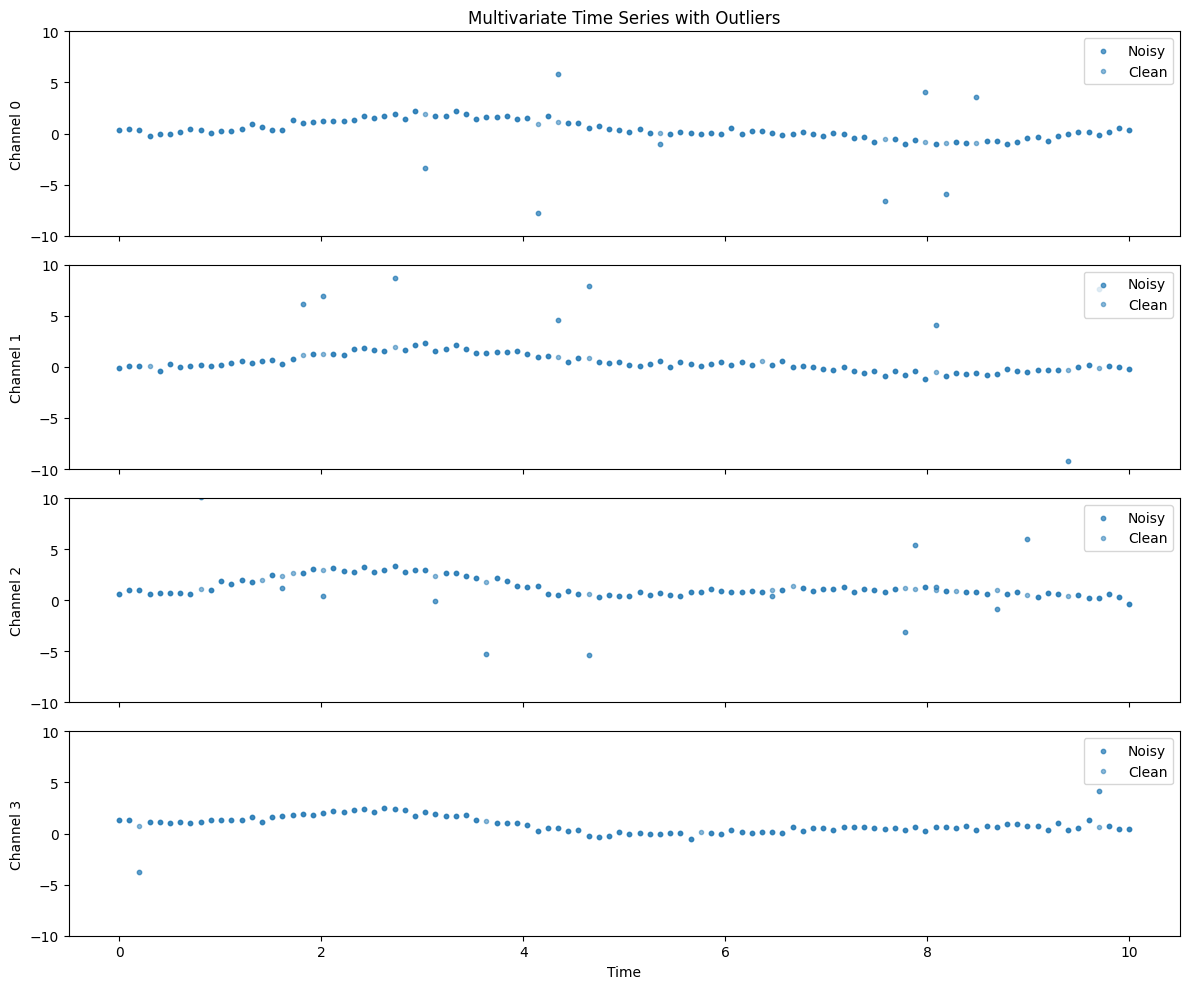

In [ ]:
ts, Ys, Ys_outliers, outliers_loc = simulate_correlated_time_series(outlier_fraction=0.1,
                                                                    outlier_scale=8,
                                                                    with_outliers=True,
                                                                    noise_std=0.2,
                                                                    )

plot_time_series_with_outliers(ts, Ys_outliers, Y_clean=Ys)

ts = tc.from_numpy(ts).to(tc.float32)
Ys = tc.from_numpy(Ys).to(tc.float32)
Ys_outliers = tc.from_numpy(Ys_outliers).to(tc.float32)

100%|██████████| 25/25 [00:02<00:00, 10.74it/s]


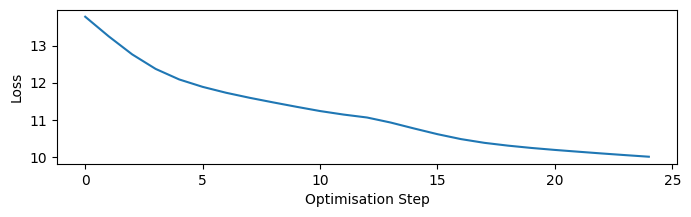

In [ ]:
outliers = True
robust = True

if outliers:
    obs = Ys_outliers
else:
    obs = Ys


gp = MultiOutputSpatioTemporalRCGP(ts=ts, Ys=obs, M=4, p=1)
if robust:
    gp.activate_robustness() 

losses = []
n_steps = 25
lr = 1e-2

excluded = {"_raw_var_y"}
params = [p for n, p in gp.named_parameters() if n not in excluded]
optimizer = tc.optim.Adam(params, lr=lr)

gp.var_y = 0.4

for step in tqdm(range(n_steps)):
    _,(preds, covs, R, Ws), _ = gp.forward(smoothing=False)
    if robust:
        loss = weighted_scoring_rule(Ys=obs, preds=preds, covs=covs, R=R, Ws=Ws)
    else:
        loss = regular_scoring_rule(Ys=obs, preds=preds, covs=covs, R=R, Ws=Ws)
    loss.backward()
    losses.append(loss.clone().detach())
    optimizer.step()  # Update parameters
    optimizer.zero_grad()  # Reset gradients

plt.figure(figsize=(8,2))
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Optimisation Step");

In [69]:
with tc.no_grad():
    (preds_smooth, stds_smooth, eff), (preds_filt, covs_filt, R, Ws_norm), (ms, Ps) = gp.forward(smoothing=True)
    print(gp.B_matrix)
    print(gp.temporal_lengthscale)
    print(gp.temporal_magnitude)
    print(gp.var_y)

TypeError: unsupported operand type(s) for *: 'NoneType' and 'Tensor'

In [70]:
def plot_predictions_with_uncertainty(
    time_steps,
    prediction,
    stds,
    data=None,
    outlier_locs=None,
    title="Predictions with 95% Confidence Intervals",
    point_size=10,
    outlier_marker_size=60,
    var_y = 0.2
):
    """
    Plot multi-channel predictions with 95% confidence intervals and clearly marked outliers.

    Args:
        time_steps: (T, 1)
        prediction: (T, C) predictive means
        stds: (T, C) predictive stds
        data: (T, C) observed data (optional)
        outlier_locs: list of (t_idx, c_idx) outlier positions (optional)
    """
    T, C = prediction.shape
    time = time_steps.squeeze()
    
    fig, axes = plt.subplots(C, 1, figsize=(10, 2.5 * C), sharex=True)
    if C == 1:
        axes = [axes]

    # Convert outlier locations to set for fast lookup
    outlier_set = set(outlier_locs) if outlier_locs is not None else set()

    for c in range(C):
        ax = axes[c]
        mean = prediction[:, c]
        std = (stds[:, c]**2 + var_y)**0.5
        lower = mean - 1.96 * std
        upper = mean + 1.96 * std

        # Prediction line and CI
        ax.plot(time, mean, label="Prediction", color='blue')
        ax.fill_between(time, lower, upper, color='blue', alpha=0.2, label="95% CI")

        if data is not None:
            # Split data into normal and outliers
            normal_mask = np.array([(t_idx, c) not in outlier_set for t_idx in range(T)])
            outlier_mask = np.array([(t_idx, c) in outlier_set for t_idx in range(T)])
            
            # Plot normal points
            ax.scatter(time[normal_mask], data[normal_mask, c], 
                       color='gray', s=point_size, label="Data", alpha=0.8)

            # Plot outliers
            if np.any(outlier_mask):
                ax.scatter(time[outlier_mask], data[outlier_mask, c], 
                           color='red', marker='x', s=outlier_marker_size, label="Outlier", zorder=5)

        ax.set_ylabel(f"Channel {c + 1}")
        ax.grid(True)
        if c == 0:
            ax.legend(loc='upper right')
        ax.set_ylim(-10, 10)  # <-- LINEAR SCALE with FIXED LIMITS

    axes[-1].set_xlabel("Time")
    fig.suptitle(title)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


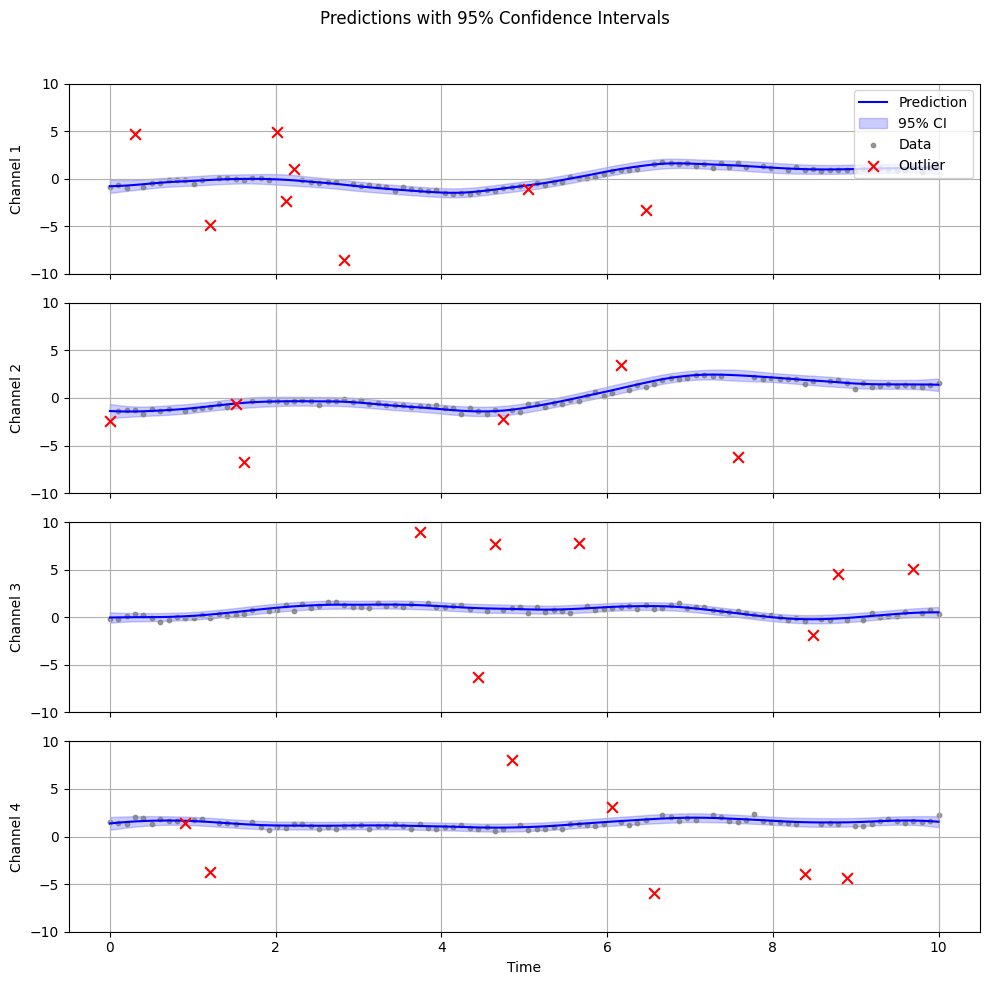

In [ ]:
plot_predictions_with_uncertainty(ts, preds_smooth, stds_smooth, data=obs, outlier_locs=outliers_loc, var_y = gp.var_y)

## Plot focused outliers

### Simulation

In [72]:
def simulate_icm_rbf_time_series(
    num_time_steps=200,
    num_channels=3,
    lengthscale=1.0,
    time_end=10.0,
    outlier_fraction=0.01,
    outlier_value=10.0,
    with_outliers=False,
    noise_std=0.1,
    seed=None,
    plot=False
):
    """
    Simulate a multivariate time series using ICM with RBF kernel and optional correlated outliers.

    Args:
        num_time_steps: Number of time steps in the time series.
        num_channels: Number of output functions (channels), must be 3.
        lengthscale: Lengthscale for the RBF kernel.
        time_end: End of the time grid.
        outlier_fraction: Fraction of time steps to receive correlated outliers in the first channel.
        outlier_value: Y value assigned to outliers.
        with_outliers: If True, adds correlated outliers to the first channel.
        noise_std: Standard deviation of Gaussian noise.
        seed: Random seed for reproducibility.
        plot: Whether to plot the time series with outliers highlighted.

    Returns:
        t: (T, 1) time grid.
        Y_clean: (T, C, 1) latent clean signals.
        Y_noisy: (T, C, 1) signals with Gaussian noise and optional outliers.
        outlier_locs: list of time indices where outliers were injected in channel 0.
    """
    assert num_channels == 3, "This function currently supports exactly 3 channels."
    
    if seed is not None:
        np.random.seed(seed)

    # Time grid
    t = np.linspace(0, time_end, num_time_steps)[:, None]  # (T, 1)

    # RBF kernel over time
    def rbf_kernel(t1, t2, lengthscale):
        sqdist = (t1[:, None] - t2[None, :]) ** 2
        return np.exp(-0.5 * sqdist / lengthscale**2)

    K_time = rbf_kernel(t.squeeze(), t.squeeze(), lengthscale)  # (T, T)

    # Intrinsic coregionalization matrix (channel covariance)
    B = np.array([
        [1.0, 0.95, 0.9],
        [0.95, 1.0, 0.95],
        [0.9, 0.95, 1.0]
    ])  # Highly correlated channels

    # Kronecker product for full covariance
    K_full = np.kron(B, K_time)  # (T*C, T*C)

    # Draw from multivariate Gaussian
    mean = np.zeros(num_time_steps * num_channels)
    y_flat = np.random.multivariate_normal(mean, K_full)

    # Reshape to (T, C, 1)
    Y_clean = y_flat.reshape(num_channels, num_time_steps).T[:, :, None]  # (T, C, 1)

    # Add Gaussian noise
    Y_noisy = Y_clean + np.random.normal(scale=noise_std, size=Y_clean.shape)

    # Inject outliers in the **middle region** of the first channel
    outlier_locs = []
    if with_outliers:
        mid_start = int(0.4 * num_time_steps)
        mid_end = int(0.6 * num_time_steps)
        candidate_indices = np.arange(mid_start, mid_end)

        num_outliers = max(1, int(outlier_fraction * num_time_steps))
        max_start = mid_end - num_outliers  # Ensure block fits inside mid_end

        start_idx = np.random.choice(np.arange(mid_start, max_start + 1))
        chosen_indices = np.arange(start_idx, start_idx + num_outliers)

        for t_idx in chosen_indices:
            Y_noisy[t_idx, 0, 0] = outlier_value
            outlier_locs.append((t_idx, 0))


    # Plotting
    if plot:
        fig, axs = plt.subplots(num_channels, 1, figsize=(10, 6), sharex=True)
        t_flat = t.squeeze()
        for c in range(num_channels):
            axs[c].plot(t_flat, Y_noisy[:, c, 0], 'o', label=f'Channel {c+1}', color='blue')
            if c == 0 and with_outliers and outlier_locs:
                outlier_times = [t[i] for i, ch in outlier_locs if ch == 0]
                axs[c].scatter(outlier_times,
                               [outlier_value]*len(outlier_times),
                               color='red', label='Outliers', zorder=5)
            axs[c].set_ylabel(f'Output {c+1}')
            axs[c].legend(loc='upper right')
            axs[c].set_ylim(-6, 6)
        axs[-1].set_xlabel('Time')
        plt.tight_layout()
        plt.show()

    Y_clean -= Y_clean.mean(axis=0, keepdims=True)
    Y_noisy -= Y_noisy.mean(axis=0, keepdims=True)

    return t, Y_clean, Y_noisy, outlier_locs


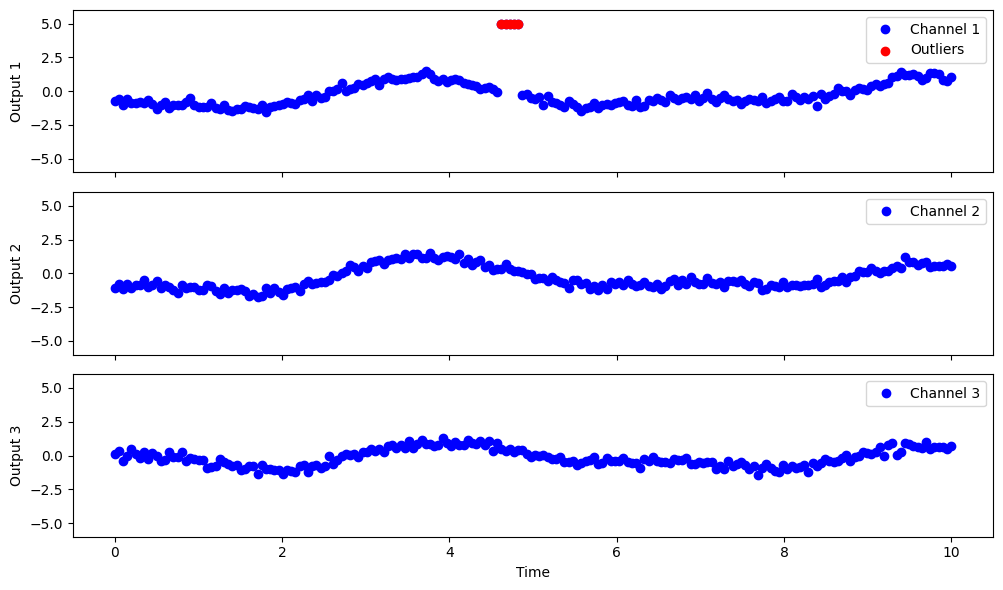

In [73]:
ts, Ys, Ys_outliers, outliers_loc = simulate_icm_rbf_time_series(
    num_time_steps=200,
    num_channels=3,
    lengthscale=1,
    time_end=10,
    outlier_fraction=0.025,
    outlier_value=5.0,
    with_outliers=True,
    noise_std=0.2,
    seed=42,
    plot=True
)

X_train = ts
Y_train = np.squeeze(Ys_outliers)

ts = tc.from_numpy(ts).to(tc.float32)
Ys = tc.from_numpy(Ys).to(tc.float32)
Ys_outliers = tc.from_numpy(Ys_outliers).to(tc.float32)

### Standard MOGP

In [75]:
initial_A = generate_A(d = 3, r = 3)
mogp = MOGPRegressor_NC(mean=0, length_scale=1, noise=0.2, A=initial_A)
mogp.fit(X_train, Y_train)
print('fitted data')
# Optimize hyperparameters
mogp.optimize_hyperparameters(print_opt_param=True, print_iter_param=True)
optim_lengthscale = mogp.length_scale
optim_noise = mogp.noise
optim_A = mogp.A
optim_B = optim_A @ optim_A.T

mu_mogp, var_mogp = mogp.predict(X_train)
std_mogp = np.sqrt(var_mogp + mogp.noise)

fitted data
-456.32057179544046
-456.3205720851365
-456.3205714127087
-456.3205705728562
-456.32057218791346
-456.3205721321452
-456.3205716998221
-456.3205718586576
-456.32057189691596
-456.3205732229259
-456.320571323587
-456.3205713531145
-439.49982148416973
-439.49982169228247
-439.49982191624224
-439.4998214319463
-439.49982147391216
-439.4998214776392
-439.49982160907524
-439.49982145784566
-439.49982149968685
-439.4998214086089
-439.49982156715646
-439.499821522436
-431.15682350458826
-431.15682391003924
-431.15682359633155
-431.1568234309981
-431.1568234712829
-431.1568235245721
-431.1568236560565
-431.156823510512
-431.15682347383677
-431.1568234177555
-431.1568235812843
-431.1568235684324
-394.16255198128573
-394.16255323326857
-394.1625513786395
-394.16255183494974
-394.1625518738407
-394.1625521013758
-394.1625522266462
-394.1625521986029
-394.1625516626377
-394.162551864028
-394.1625519614579
-394.16255228350064
-677.8681931261431
-677.8681894420638
-677.8681919787185
-677

In [76]:
print(optim_B)
print(optim_noise)

[[1.61770959 0.43233426 0.25455873]
 [0.43233426 0.32768077 0.21559182]
 [0.25455873 0.21559182 0.18546322]]
0.06689857028014498


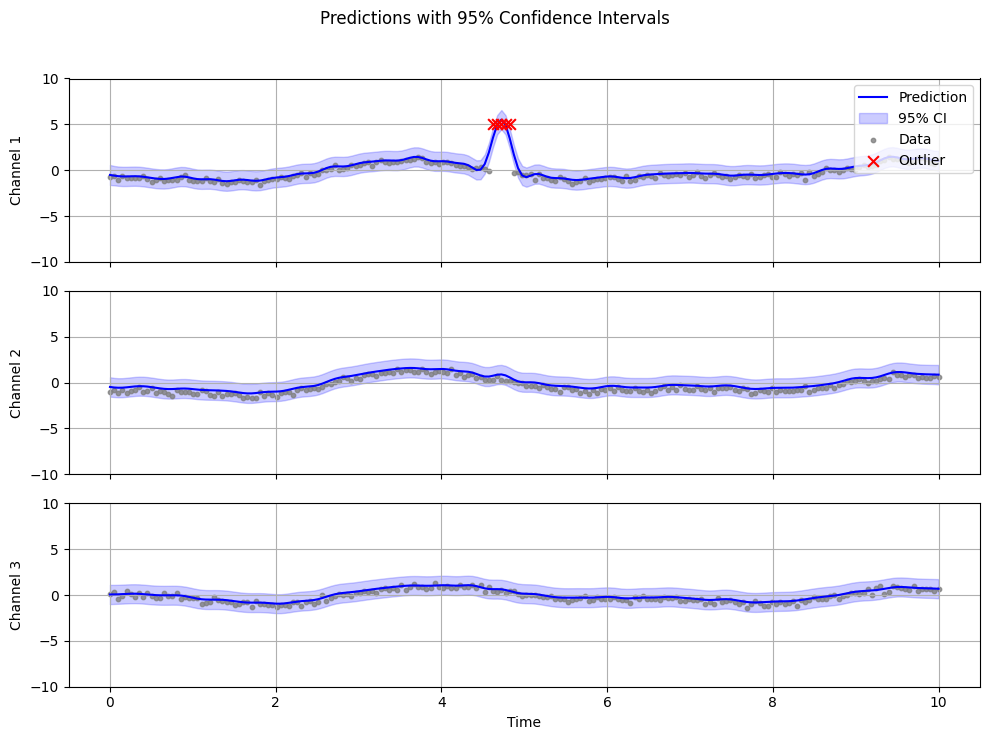

In [77]:
plot_predictions_with_uncertainty(ts, mu_mogp, std_mogp, data=obs, outlier_locs=outliers_loc)

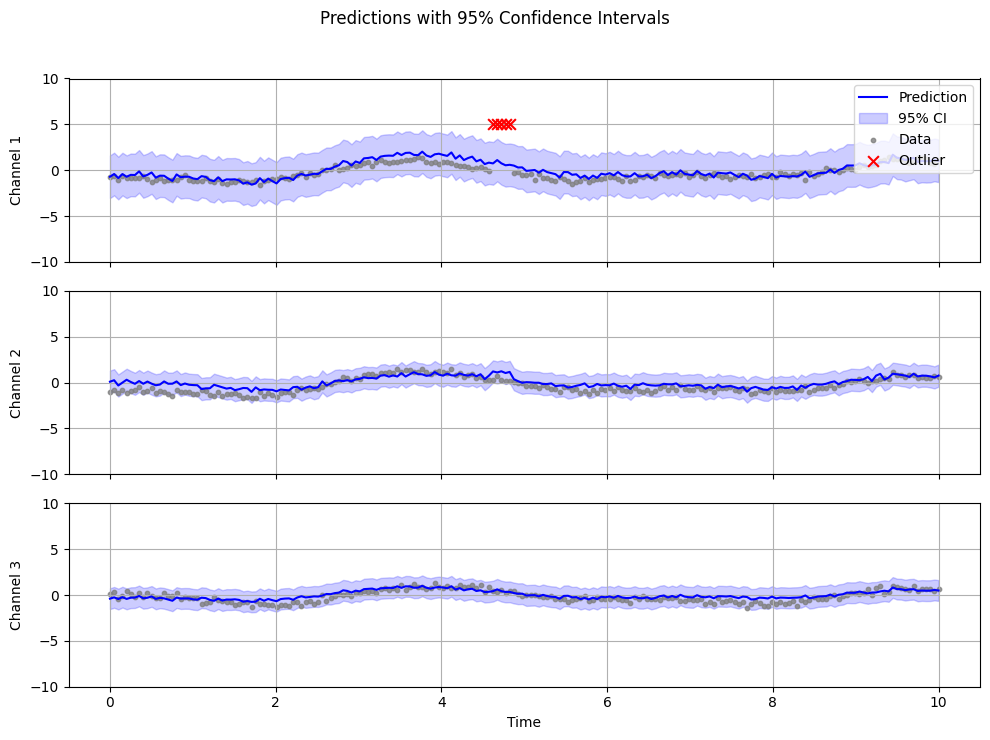

In [78]:
def extract_and_remove_dth_numpy(matrix, d):
    row_without_diag = np.delete(matrix[d, :], d)
    diag_elem = matrix[d, d]
    reduced_matrix = np.delete(np.delete(matrix, d, axis=0), d, axis=1)

    return row_without_diag, diag_elem, reduced_matrix

def cross_channel_predictive_numpy(Y_train, mean, B, noise):
        N, D = Y_train.shape
        if np.isscalar(noise):
            noise_matrix = noise * np.eye(D)
        else:
            noise_matrix = np.diag(noise.flatten())
        B_noise = B + noise_matrix
        predictive_means, predictive_variances = np.zeros(Y_train.shape), np.zeros(Y_train.shape)
        
        for i in range(N):
            row = Y_train[i, :]
            for d in range(D):
                if np.isnan(row[d]):
                    predictive_means[i, d] = np.nan
                    predictive_variances[i, d] = np.nan
                else:
                    obs_other = np.delete(row, d)
                    B_d_other, B_dd, B_other_other = extract_and_remove_dth_numpy(B_noise, d)

                    # Mask to filter out NaNs
                    mask = ~np.isnan(obs_other)
                    if not np.any(mask):
                        # If all values in obs_other are NaN
                        conditional_mean = mean
                        conditional_variance = B_dd
                    else:
                        B_d_other_masked = B_d_other[mask]
                        B_other_other_masked = B_other_other[np.ix_(mask, mask)] + 1e-3 * np.eye(len(B_other_other[np.ix_(mask, mask)]))
                        obs_other_masked = obs_other[mask]

                        conditional_mean = (
                            mean +
                            B_d_other_masked.reshape(1, -1) @
                            np.linalg.inv(B_other_other_masked) @
                            (obs_other_masked.reshape(-1, 1) - mean)
                        ).item()
                        conditional_variance = (
                            B_dd -
                            B_d_other_masked.reshape(1, -1) @
                            np.linalg.inv(B_other_other_masked) @
                            B_d_other_masked.reshape(-1, 1)
                        ).item()

                    predictive_means[i, d] = conditional_mean
                    predictive_variances[i, d] = conditional_variance

        return predictive_means, predictive_variances

predictive_means, predictive_vars = cross_channel_predictive_numpy(Y_train=Y_train, mean=0, B=optim_B, noise=optim_noise)
plot_predictions_with_uncertainty(ts, predictive_means, np.sqrt(predictive_vars), data=obs, outlier_locs=outliers_loc)

### Temporal MORCGP

100%|██████████| 25/25 [00:06<00:00,  4.15it/s]


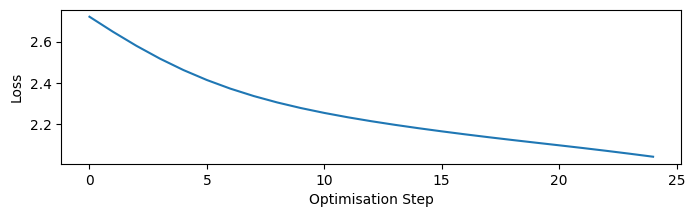

In [79]:
outliers = True
robust = True

if outliers:
    obs = Ys_outliers
else:
    obs = Ys


gp = MultiOutputSpatioTemporalRCGP_fixed_weights(ts=ts, Ys=obs, M=3, p=1)
if robust:
    gp.activate_robustness() 

losses = []
n_steps = 25
lr = 1e-2

# excluded = {"_raw_var_y"}
# params = [p for n, p in gp.named_parameters() if n not in excluded]
params = [p for n, p in gp.named_parameters()]
optimizer = tc.optim.Adam(params, lr=lr)

gp.var_y = 0.4

for step in tqdm(range(n_steps)):
    _,(preds, covs, R, Ws), _ = gp.forward(smoothing=False, B_weighted=tc.from_numpy(optim_B).to(tc.float32), noise_weighted=tc.tensor(optim_noise, dtype=tc.float32))
    if robust:
        loss = weighted_scoring_rule(Ys=obs, preds=preds, covs=covs, R=R, Ws=Ws)
    else:
        loss = regular_scoring_rule(Ys=obs, preds=preds, covs=covs, R=R, Ws=Ws)
    loss.backward()
    losses.append(loss.clone().detach())
    optimizer.step()  # Update parameters
    optimizer.zero_grad()  # Reset gradients

plt.figure(figsize=(8,2))
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Optimisation Step");

In [80]:
with tc.no_grad():
    temporal_MORCGP_B = gp.B_matrix
    temporal_MORCGP_var_y = gp.var_y

In [81]:
with tc.no_grad():
    (preds_smooth, stds_smooth, eff), (preds_filt, covs_filt, R, Ws_norm), (ms, Ps) = gp.forward(smoothing=True, B_weighted=temporal_MORCGP_B, noise_weighted=temporal_MORCGP_var_y)
    print(gp.B_matrix)
    print(gp.temporal_lengthscale)
    print(gp.temporal_magnitude)
    print(gp.var_y)

tensor([[ 0.2587,  0.0348,  0.2872],
        [ 0.0348,  0.2086, -0.0443],
        [ 0.2872, -0.0443,  0.3641]])
tensor(1.2109)
tensor(1.3290)
tensor(0.3231)


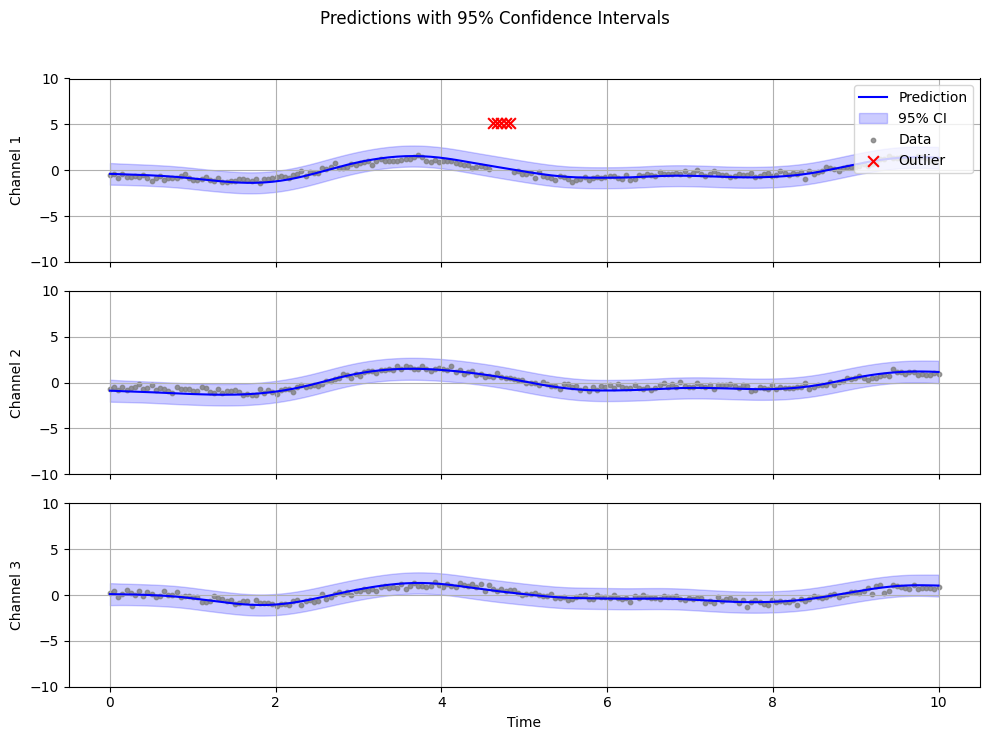

In [82]:
plot_predictions_with_uncertainty(ts, preds_smooth, stds_smooth, data=obs, outlier_locs=outliers_loc, var_y=temporal_MORCGP_var_y)

### STRCGP

In [50]:
outliers = True
robust = True

if outliers:
    obs = Ys_outliers
else:
    obs = Ys


gp = MultiOutputSpatioTemporalRCGP(ts=ts, Ys=obs, M=3, p=1)
if robust:
    gp.activate_robustness() 

losses = []
n_steps = 25
lr = 1e-2

# excluded = {"_raw_var_y"}
params = [p for n, p in gp.named_parameters() if n not in excluded]
optimizer = tc.optim.Adam(params, lr=lr)

gp.var_y = 0.4

for step in tqdm(range(n_steps)):
    _,(preds, covs, R, Ws), _ = gp.forward(smoothing=False)
    if robust:
        loss = weighted_scoring_rule(Ys=obs, preds=preds, covs=covs, R=R, Ws=Ws)
    else:
        loss = regular_scoring_rule(Ys=obs, preds=preds, covs=covs, R=R, Ws=Ws)
    loss.backward()
    losses.append(loss.clone().detach())
    optimizer.step()  # Update parameters
    optimizer.zero_grad()  # Reset gradients

plt.figure(figsize=(8,2))
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Optimisation Step");

NameError: name 'MultiOutputSpatioTemporalRCGP' is not defined

In [210]:
with tc.no_grad():
    (preds_smooth, stds_smooth, eff), (preds_filt, covs_filt, R, Ws_norm), (ms, Ps) = gp.forward(smoothing=True)
    print(gp.B_matrix)
    print(gp.temporal_lengthscale)
    print(gp.temporal_magnitude)
    print(gp.var_y)

tensor([[ 0.4181, -0.0731,  0.0291],
        [-0.0731,  0.2386,  0.1635],
        [ 0.0291,  0.1635,  0.1698]])
tensor(1.1809)
tensor(1.4487)
tensor(0.4000)


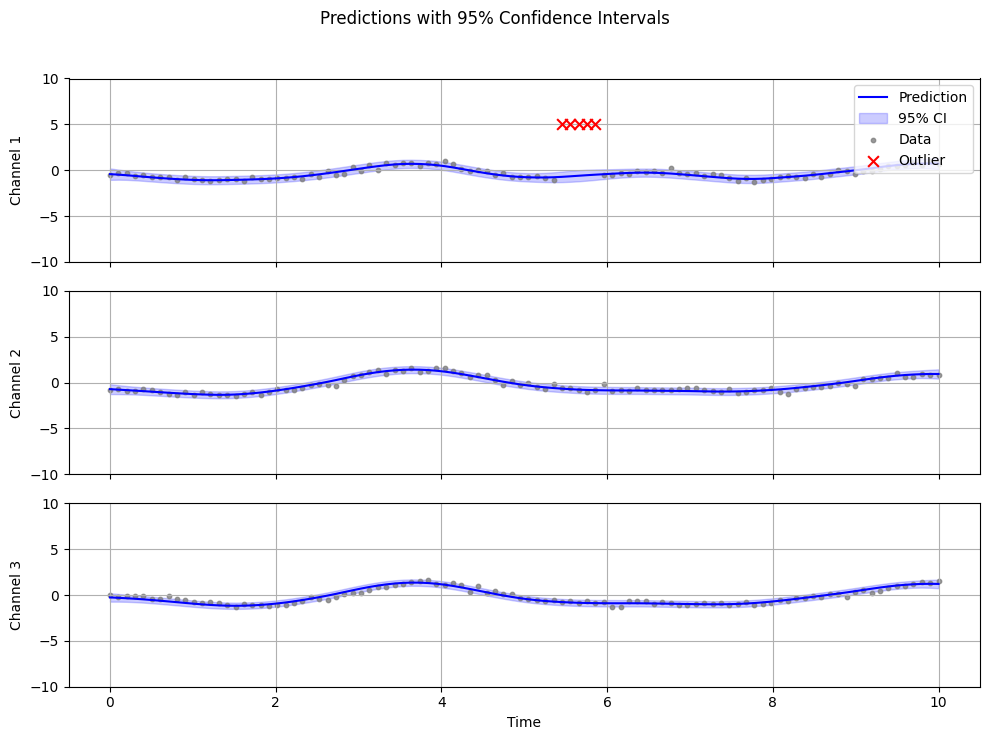

In [211]:
plot_predictions_with_uncertainty(ts, preds_smooth, stds_smooth, data=obs, outlier_locs=outliers_loc)

# Sparse Experiment

In [14]:
data = np.load('data.npz')
ts = tc.from_numpy(data["ts"])
grids = tc.from_numpy(data["grids"])
true_Ys = tc.from_numpy(data["true_Ys"])
Ys = tc.from_numpy(data["Ys"])
Ys_no_outliers = tc.from_numpy(data["Ys_no_outliers"])
outliers_loc = tc.from_numpy(data["outliers_loc"])
n_lon = tc.from_numpy(data["n_lon"])
n_lat = tc.from_numpy(data["n_lat"])
lon_norm = tc.from_numpy(data["lon_norm"])
lat_norm = tc.from_numpy(data["lat_norm"])

100%|██████████| 16/16 [00:02<00:00,  7.24it/s]


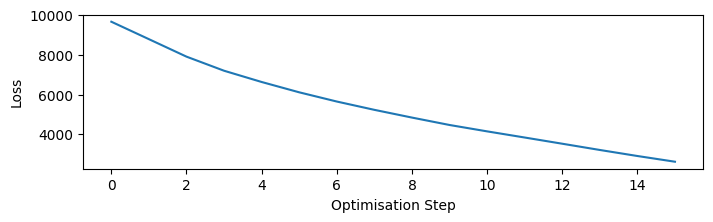

In [20]:
gp = SparseSpatioTemporalRCGP(ts=ts, grid=grids[0], Ys=Ys, sparse_pts=30, p=1)

gp.activate_robustness(func="constant") 
gp.c=0.5
gp._K_w_lengthscale = 1.

losses = []
n_steps = 16
lr = 0.25

optimizer = tc.optim.Adam(gp.parameters(), lr=lr)

for step in tqdm(range(n_steps)):
    _,(preds, covs, R, Ws), _ = gp.forward(smoothing=False)
    #loss = scoring_rule(Ys=Ys, preds=preds, covs=covs, R=R, Ws=Ws)
    loss = tc.abs(preds - true_Ys).sum()
    loss.backward()
    losses.append(loss.clone().detach())
    optimizer.step()  # Update parameters
    optimizer.zero_grad()  # Reset gradients

plt.figure(figsize=(8,2))
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Optimisation Step");

In [21]:
with tc.no_grad():
    (preds_smooth, stds_smooth, eff), (preds_filt, covs_filt, R, Ws_norm), (ms, Ps) = gp.forward(smoothing=True)

    print(tc.abs(preds_smooth - true_Ys.squeeze(-1)).sum())

tensor(868.4207)


Mean Absolute Difference (Data - No Outliers) :  101.3565444946289
Mean Absolute Difference (Prediction) :  121.039794921875
Mean Absolute Difference (Data - No Outliers) :  97.08243560791016
Mean Absolute Difference (Prediction) :  102.84538269042969
Mean Absolute Difference (Data - No Outliers) :  98.51832580566406
Mean Absolute Difference (Prediction) :  88.71378326416016
Mean Absolute Difference (Data - No Outliers) :  100.95301818847656
Mean Absolute Difference (Prediction) :  81.20268249511719
Mean Absolute Difference (Data - No Outliers) :  93.23451232910156
Mean Absolute Difference (Prediction) :  70.5653305053711
Mean Absolute Difference (Data - No Outliers) :  97.20365142822266
Mean Absolute Difference (Prediction) :  66.82640075683594
Mean Absolute Difference (Data - No Outliers) :  100.76924896240234
Mean Absolute Difference (Prediction) :  67.43675994873047
Mean Absolute Difference (Data - No Outliers) :  98.46554565429688
Mean Absolute Difference (Prediction) :  77.326301

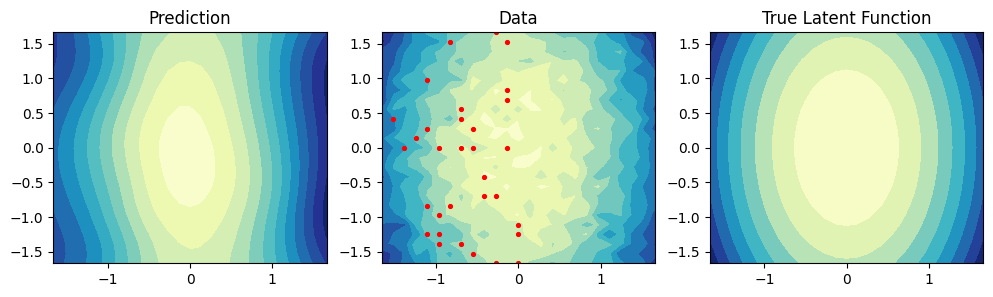

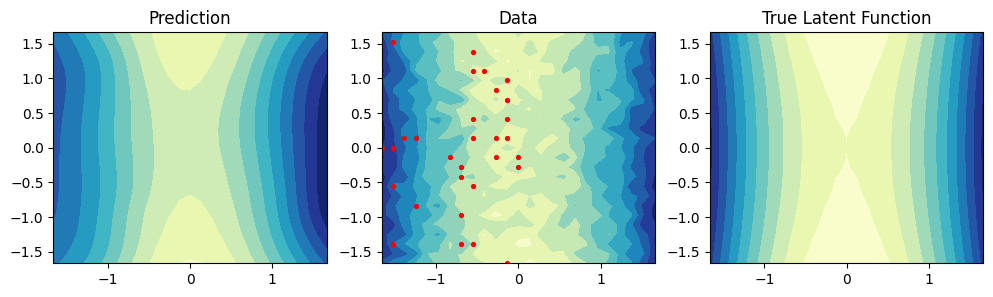

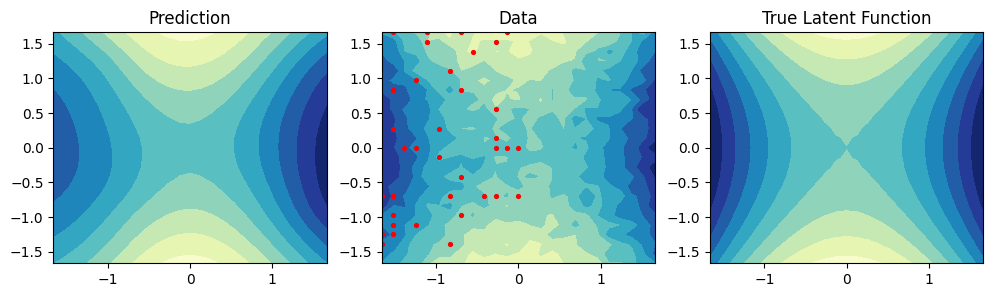

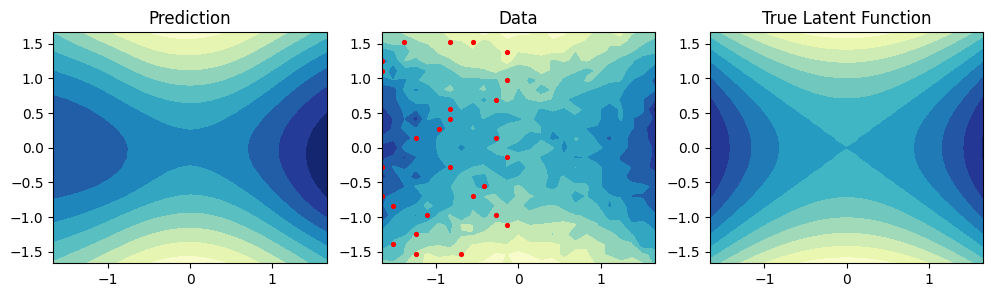

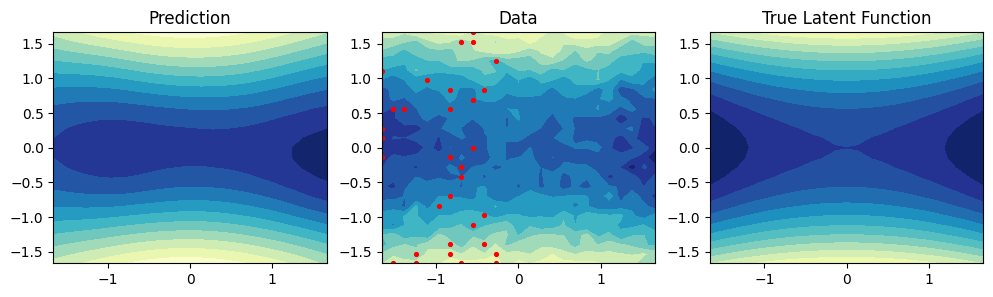

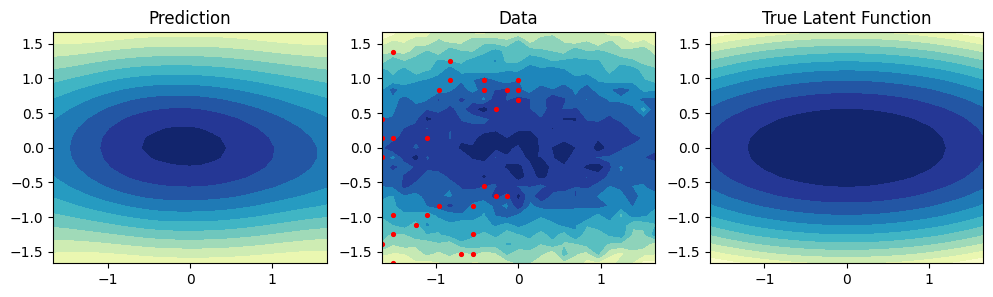

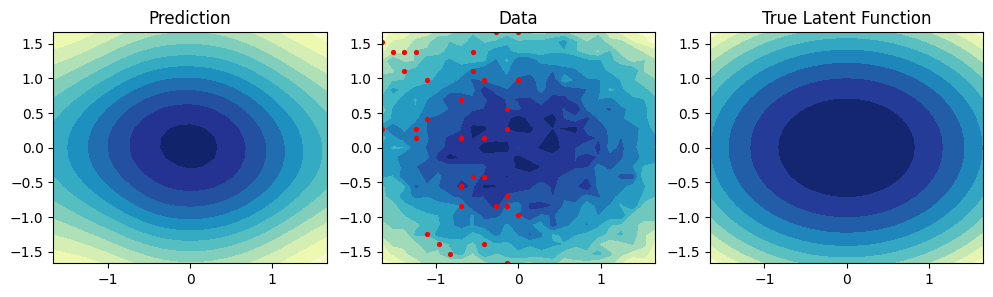

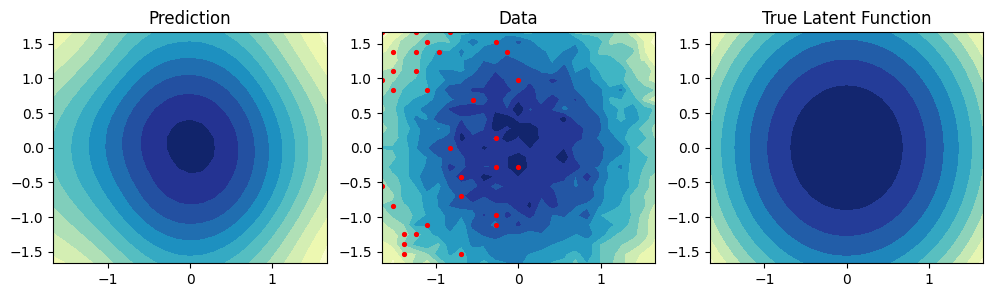

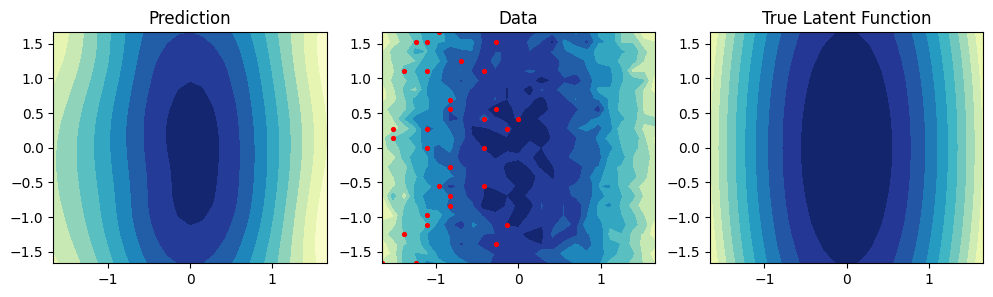

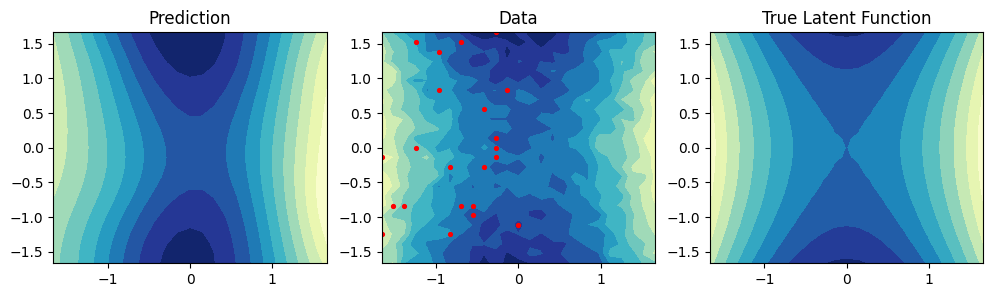

In [24]:
for i in range(10):
    plot(idx=i, grid=grids[0], ts=ts, pred=preds_smooth, Ys=Ys, Ys_no_outliers=Ys_no_outliers, outliers_loc=outliers_loc, true_Ys=true_Ys, n_lon=n_lon, n_lat=n_lat)